How to stay on top: Investigating  transfer policies and  player develpoment of the Bundesliga's most dominant teams

Project Proposal


#  Aims, objectives and background

## Introduction

In my project proposal, I scraped data from transfermarkt.com to explore the transfer policies and player development of FC Bayern Munich and Borissia Dortmund.

Since the 2009/2010 season FC Bayern Munich (FCB) has won the German Bundesliga an astounding amount of ten times, only losing out to Borussia Dortmund (BVB) in the seasons 10/11 and 11/12.
And even in the seasons, Munich did not win, they managed to stay in the top 3 with a final league standing of third and second in the seasons 10/11 and 11/12 respectively[1].

Since 2009 Dortmund only won the Bundesliga two times but get second in the final league standings 6 times.
Staying on top for this long is a remarkable achievement by both organizations and teams. Because those two teams have been dominant this long, they must be doing something right in regards to player development and their approach to transfers. Otherwise, they would not be able to field consistently winning teams for over a decade. 

There are several factors at play as to why a soccer team performs well and as to how a club is managed well. I wanted to explore the idea of using statistical analysis and data science techniques to compare and create metrics and to gain insights into how to stay on top of a league this long. In my opinion, it is especially interesting to compare those two clubs and their approaches and if their approaches changed over the years.


## Aims and Objectives

Within this project I would like to explore the following:
-	How do FCB and BVB approach their transfer strategy? Are they buying well-known superstars for a lot of money or are they 
    taking their chances with cheaper rookies?
-	Has their approach changes over the years or e.g., after not winning the league?
-	How well is their transfer strategy panning out? Do newly bought players perform well immediately or are they flopping?
-	How well are both teams developing their players? Are the players getting better/worse?
-	Do they promote a lot of young players from their second division? Are those players getting enough time to adapt?
-	How long are new transfers staying on the team? Do they become key players?

# Implementation

In [338]:
# Importing libraries
from lxml import etree
from urllib import request
import pandas as pd
import re
import matplotlib.pyplot as plt
import unittest


# Show all matplotlib graphs inline
%matplotlib inline

## Webscraping: defining functions

Prior to scraping the content of the different URLs, we need to define several functions which we can call to scrape the data.

The functions return the extracted information in the form of a pandas DataFrame.

Scraping can take a minute or two!

In [339]:
# range of seasons to scrape  and base_url for the fbref webpages
seasons = range(2010, 2021)


base_url_fcb = "https://fbref.com/en/squads/054efa67/{season_start}-{season_end}/Bayern-Munich-Stats"
base_url_bvb = "https://fbref.com/en/squads/add600ae/{season_start}-{season_end}/Dortmund-Stats"

In [340]:
# function to request an HTML page from www.transfermarkt.co.uk or fbref.com/en/
def request_page(url):
    opener = request.build_opener()
    # set Mozilla/5.0 as User-agent in order to receive a response from the webserver
    # the site's robots.txt requires a user-agent to be set
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    # request the page
    response = opener.open(url)
    # use lxml's HTML parser
    htmlparser = etree.HTMLParser()
    # parse the document in order to obtain a tree of nodes
    tree = etree.parse(response, htmlparser)
    return tree

In [341]:
# function to parse the HTML page containing the transfers of the specified club
# direction defines the type of the club's transfers (i.e. "in" or "out)
def read_transfers_table(tree, *, club, direction):
    # parse direction parameter
    direction = direction.lower()
    if direction == "in":
        # the "in" transfers are in table number 1
        table_number = 1
    elif direction == "out":
        # the "out" transfers are in table number 2
        table_number = 2
    else:
        # only allow those two directions; otherwise throw an error
        raise ValueError("Invalid direction: " + direction)

    # XPath to the rows inside the table containing the club's transfers
    rows = tree.xpath('//div[div/a/@title="{club}"]/div[@class="responsive-table"][{table_number}]//tbody/tr'
                      .format(club=club, table_number=table_number))
    data = []
    # extract the information for each table row
    for r in rows:
        name = r.xpath('td[1]/div/span[@class="hide-for-small"]/a/@title')[0]
        age = r.xpath('td[2]/text()')[0]
        # nat = r.xpath('td[3]/text()')[0]
        position = r.xpath('td[4]/text()')[0]
        market_value = r.xpath('td[6]/text()')[0]
        # in some cases, there is no hyperlink element
        # instead, the data is stored directly as text in the parent element
        if len(r.xpath('td[8]/a')):
            # extract the data from the link element if the hyperlink element exists
            left_joined = r.xpath('td[8]/a/text()')[0].strip()
        else:
            # otherwise, extract the data directly from the text of the parent element
            left_joined = r.xpath('td[8]/text()')[0].strip()
        fee = r.xpath('td[9]/a/text()')[0]
        # add the information extracted from the row to the data list
        data.append([club, direction, name, age, position, market_value, left_joined, fee])

    # create a DataFrame from the raw data
    return pd.DataFrame(data=data, columns=["club", "direction", "name", "age", "position", "market_value",
                                            "left_joined", "fee"])

In [342]:
#function  reading player table and returninga DataFrame
def read_players_table(tree, *, club):
    # XPath to the rows inside the table containing the statistics of the club's players
    rows = tree.xpath('//*[@id="yw1"]/table/tbody/tr')
    data = []
    # extract the information for each table row
    for r in rows:
        name = r.xpath('td[2]//tr[1]/td[@class="hauptlink"]//span[@class="hide-for-small"]/a/text()')[0]
        position = r.xpath('td[2]//tr[2]/td/text()')[0]
        age = r.xpath('td[3]/text()')[0]
        # nat = r.xpath('td[4]/text()')[0]
        in_squad = r.xpath('td[5]/text()')[0]
        # in some cases, the appearances table disk spans multiple columns and is used for additional information
        # about the player
        if int(r.xpath('td[6]/@colspan')[0]) > 1:
            # if the colspan attribute is greater than 1, than the element spans multiple columns
            # in this case, appearances is set to "-" and the element's text is additional information
            appearances = "-"
            info = r.xpath('td[6]/text()')[0]
        else:
            # else, the element's text is the number of appearances and there is no additional information
            appearances = r.xpath('td[6]/text()')[0]
            info = "-"
        goals = r.xpath('td[7]/text()')[0]
        assists = r.xpath('td[8]/text()')[0]
        yellow_cars = r.xpath('td[9]/text()')[0]
        second_yellow_cards = r.xpath('td[10]/text()')[0]
        red_cards = r.xpath('td[11]/text()')[0]
        substitutions_on = r.xpath('td[12]/text()')[0]
        substitutions_off = r.xpath('td[13]/text()')[0]
        ppg = r.xpath('td[14]/text()')[0]
        minutes_played = r.xpath('td[15]/text()')[0]

        # add the information extracted from the row to the data list
        data.append([club, name, age, position, in_squad, appearances, goals, assists, yellow_cars, second_yellow_cards,
                     red_cards, substitutions_on, substitutions_off, ppg, minutes_played, info])

    # create a DataFrame from the raw data
    return pd.DataFrame(data=data, columns=["club", "name", "age", "position", "in_squad", "appearances", "goals",
                                            "assists", "yellow_cards", "second_yellow_cards", "red_cards",
                                            "substitutions_on", "substitutions_off", "ppg", "minutes_played", "info"])


Sometimes the xpath element was empty, e.g if a player was not playing or in the squad a lot during season so most of the entires were empty instead of 0. The following functions is about this edge case and returns a 0 if the xpath element is empty, so I don't get an Error.

In [343]:
# edge case fbref empty xpath element
def xpath_default(tree, xpath, default=0):
    result = tree.xpath(xpath)
    return result[0] if len(result) else default

In [344]:
# function to parse the HTML page containing the transfers of the specified club
# direction defines the type of the club's transfers (i.e. "in" or "out)
def read_table_fbref(tree):

    # XPath to the rows inside the table containing the squads player stats for whole season
    rows = tree.xpath('//*[starts-with(@id, "stats_standard_")]/tbody/tr')
    
    data = []
    # extract the information for each table row
    for r in rows:
        name = xpath_default(r, 'th/a/text()')
        pos = xpath_default(r, 'td[2]/text()')
        age = xpath_default(r, 'td[3]/text()')
        mp = xpath_default(r, 'td[3]/text()')
        starts = xpath_default(r, 'td[5]/text()')
        m = xpath_default(r, 'td[6]/text()')
        minutes = xpath_default(r, 'td[6]/text()')
        gls = xpath_default(r, 'td[8]/text()')
        ast = xpath_default(r, 'td[9]/text()')
        g_pk = xpath_default(r, 'td[10]/text()')
        PK = xpath_default(r, 'td[11]/text()')
        PKatt = xpath_default(r, 'td[12]/text()')
        crdY = xpath_default(r, 'td[13]/text()')
        crdR = xpath_default(r, 'td[14]/text()')
        
        # add the information extracted from the row to the data list
        data.append([name, pos, age, mp, starts, minutes, gls, ast, g_pk, PK, PKatt, crdY, crdR])

    # create a DataFrame from the raw data
    return pd.DataFrame(data=data, columns=['name', 'pos', 'age', 'mp', 'starts', 'minutes', 'gls', 'ast', 'g_pk', 'PK', 'PKatt', 'crdY', 'crdR'])

In [345]:
# function to request the transfers page of a single season
def scrape_transfers_page(*, season):
    # build the correct URL for the corresponding season
    url = transfers_base_url.format(season=season)

    # request the page and parse it
    tree = request_page(url)

    # DataFrame to contain the data of all specified clubs in the specified season
    df = pd.DataFrame()
    for club in clubs:
        # read the in transfers table
        in_transfers_data = read_transfers_table(tree, club=club, direction="in")
        # set the season in the season column
        in_transfers_data["season"] = season

        # read the out transfers table
        out_transfers_data = read_transfers_table(tree, club=club, direction="out")
        # set the season in the season column
        out_transfers_data["season"] = season

        # add the in and out transfers of the current club to the DataFrame containing all data for the season
        df = pd.concat([df, in_transfers_data, out_transfers_data], ignore_index=True)

    return df

In [346]:
# function to request the player statistics page of a single season
def scrape_players_page(*, base_url, season):
    # build the correct URL for the corresponding season
    url = base_url.format(season=season)

    # request the page and parse it
    tree = request_page(url)

    # DataFrame to contain the data of all specified clubs in the specified season
    df = pd.DataFrame()
    if base_url == players_base_url_fcb:
        # read the player statistics table
        players_data = read_players_table(tree, club="Bayern Munich")
        # set the season in the season column
        players_data["season"] = season

        # add the player statistics of the current club to the DataFrame containing all data for the season
        df = pd.concat([df, players_data], ignore_index=True)
    elif base_url == players_base_url_bvb:
        # read the player statistics table
        players_data = read_players_table(tree, club="Borussia Dortmund")
        # set the season in the season column
        players_data["season"] = season

        # add the player statistics of the current club to the DataFrame containing all data for the season
        df = pd.concat([df, players_data], ignore_index=True)

    return df


In [347]:
# function to request the transfers page of a single season
def scrape_page(*, base_url, season):
    # build the correct URL for the corresponding season
    url = base_url.format(season_start=season, season_end=season+1)

    # request the page and parse it
    tree = request_page(url)

    # DataFrame to contain the data of all specified clubs in the specified season
    df = pd.DataFrame()
    
    # read the table
    table_data = read_table_fbref(tree)
    # set the season in the season column
    table_data["season"] = season

    # add the in and out transfers of the current club to the DataFrame containing all data for the season
    df = pd.concat([df, table_data], ignore_index=True)

    return df

In [348]:
# function scraping the transfer data and returning a DataFrame
def scrape_transfers():
    # DataFrame to contain the data of all specified seasons
    df = pd.DataFrame()
    for year in seasons:
        # scrape the transfer data for the current season
        season_data = scrape_transfers_page(season=year)
        # add the transfers of the current season to the DataFrame containing the data of all seasons
        df = pd.concat([df, season_data], ignore_index=True)
    return df

In [349]:
# function scraping the transfer data and returning a DataFrame
def scrape_stats(*, base_url):
    # DataFrame to contain the data of all specified seasons
    df = pd.DataFrame()
    for year in seasons:
        # scrape the transfer data for the current season
        season_data = scrape_page(base_url=base_url, season=year)
        # add the transfers of the current season to the DataFrame containing the data of all seasons
        df = pd.concat([df, season_data], ignore_index=True)
    return df

In [350]:
# function scraping the player statistics data and returning a DataFrame
def scrape_players():
    # DataFrame to contain the data of all specified seasons
    df = pd.DataFrame()
    for year in seasons:
        for base_url in players_base_urls:
            # scrape the player statistics data for the current season
            #season_players_data = scrape_players_page(season=year, base_url=players_base_url_fcb)
            season_players_data = scrape_players_page(season=year, base_url=base_url)
            # add the player statistics of the current season to the DataFrame containing the data of all seasons
            df = pd.concat([df, season_players_data], ignore_index=True)
    return df


## Webscraping: extracting information

First the transfer history of the clubs will be scraped. Then the players statistics from transfermarkt.com for each season and at last the statistics of the players from fbref.com

The Season column will be named after the  Year in which season started. e.g. 2010 = season 2010/2011.

In [351]:
# range of seasons to scrape  
seasons = range(2010, 2021)

#base_url for the fbref webpages
base_url_fcb = "https://fbref.com/en/squads/054efa67/{season_start}-{season_end}/Bayern-Munich-Stats"
base_url_bvb = "https://fbref.com/en/squads/add600ae/{season_start}-{season_end}/Dortmund-Stats"

# list of clubs to scrape
clubs = ["Bayern Munich", "Borussia Dortmund"]

# URL to retrieve transfers from
transfers_base_url = "https://www.transfermarkt.co.uk/bundesliga/transfers/wettbewerb/L1/plus/?saison_id={season}&s_w=&leihe=1&intern=0&intern=1"

#players_base_url_fcb = "https://www.transfermarkt.co.uk/bayern-munich/leistungsdaten/verein/27/plus/1?reldata=%26{season}"
#players_base_url_bvb = "https://www.transfermarkt.co.uk/borussia-dortmund/leistungsdaten/verein/16/plus/1?reldata=%26{season}"


players_base_url_fcb= "https://www.transfermarkt.co.uk/bayern-munich/leistungsdaten/verein/27/plus/1?reldata=L1%26{season}"
players_base_url_bvb = "https://www.transfermarkt.co.uk/borussia-dortmund/leistungsdaten/verein/16/plus/1?reldata=L1%26{season}"
# list of URLs of the clubs to scrape for transfermarkt
#players_base_urls = [
#    "https://www.transfermarkt.co.uk/bayern-munich/leistungsdaten/verein/27/plus/1?reldata=%26{season}",
#    "https://www.transfermarkt.co.uk/borussia-dortmund/leistungsdaten/verein/16/plus/1?reldata=%26{season}"
#]

players_base_urls =[players_base_url_fcb,players_base_url_bvb]

In [352]:
# get a DataFrame containing the transfers by scraping www.transfermarkt.co.uk
transfers = scrape_transfers()
transfers.to_csv("transfers.csv", index=False)

# get a DataFrame containing the players stats by scraping www.transfermarkt.co.uk
players = scrape_players()
players.to_csv("players.csv", index=False)

# get a DataFrame containing the players stats by scraping fbref.com
fbref_fcb = scrape_stats(base_url=base_url_fcb)
fbref_bvb = scrape_stats(base_url=base_url_bvb)
fbref_fcb.to_csv("players.csv", index=False)
fbref_bvb.to_csv("players.csv", index=False)

In [353]:
display(transfers)

,club,direction,name,age,position,market_value,left_joined,fee,season
0,Bayern Munich,in,Luiz Gustavo,23,Defensive Midfield,£2.16m,TSG Hoffenheim,£15.30m,2010
1,Bayern Munich,in,David Alaba,18,Centre-Back,£49.50m,FC Bayern II,-,2010
2,Bayern Munich,in,José Sosa,25,Central Midfield,£810Th.,Estudiantes,End of loan,2010
3,Bayern Munich,in,Luca Toni,33,Centre-Forward,-,AS Roma,End of loan,2010
4,Bayern Munich,in,Breno,20,Centre-Back,£180Th.,1.FC Nuremberg,End of loan,2010
...,...,...,...,...,...,...,...,...,...
465,Borussia Dortmund,out,Marius Wolf,25,Right Winger,£4.50m,1. FC Köln,loan transfer,2020
466,Borussia Dortmund,out,Immanuel Pherai,19,Attacking Midfield,£630Th.,PEC Zwolle,loan transfer,2020
467,Borussia Dortmund,out,André Schürrle,29,Left Winger,-,Retired,-,2020
468,Borussia Dortmund,out,Achraf Hakimi,21,Right-Back,£63.00m,Real Madrid,End of loan,2020


In [354]:
display(players)

,club,name,age,position,in_squad,appearances,goals,assists,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,ppg,minutes_played,info,season
0,Bayern Munich,Maximilian Riedmüller,22,Goalkeeper,-,-,-,-,-,-,-,-,-,0,-,Not in squad during this season,2010
1,Bayern Munich,Hans Jörg Butt,36,Goalkeeper,34,23,-,-,-,-,-,1,-,1.96,2.024',-,2010
2,Bayern Munich,Rouven Sattelmaier,22,Goalkeeper,-,-,-,-,-,-,-,-,-,0,-,Not in squad during this season,2010
3,Bayern Munich,Thomas Kraft,21,Goalkeeper,34,12,-,1,-,-,-,-,1,1.92,1.035',-,2010
4,Bayern Munich,David Alaba,18,Centre-Back,5,2,-,-,-,-,-,2,-,2.00,22',-,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,Borussia Dortmund,Youssoufa Moukoko,15,Centre-Forward,18,14,3,-,-,-,-,12,1,1.14,410',-,2020
724,Borussia Dortmund,Marius Wolf,25,Right Winger,2,-,-,-,-,-,-,-,-,0,-,Not used during this season,2020
725,Borussia Dortmund,Ansgar Knauff,18,Right Winger,7,4,1,1,-,-,-,4,-,1.75,68',-,2020
726,Borussia Dortmund,Steffen Tigges,21,Centre-Forward,14,6,-,-,-,-,-,6,-,1.50,49',-,2020


In [355]:
display(fbref_fcb)

,name,pos,age,mp,starts,minutes,gls,ast,g_pk,PK,PKatt,crdY,crdR,season
0,Philipp Lahm,"DF,MF",26,26,34,"3,060",3,2,1,2,3,3,0,2010
1,Thomas Müller,"FW,MF",20,20,32,"2,788",12,11,12,0,0,2,0,2010
2,Bastian Schweinsteiger,"DF,MF",25,25,31,"2,728",4,6,4,0,1,6,0,2010
3,Mario Gómez,FW,25,25,27,"2,443",28,2,27,1,2,2,0,2010
4,Anatoliy Tymoshchuk,"DF,MF",31,31,23,"1,992",3,1,3,0,0,3,0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,Dimitri Oberlin,"FW,MF",22,22,0,0,0,0,0,0,0,0,0,2020
318,Armindo Sieb,FW,17,17,0,0,0,0,0,0,0,0,0,2020
319,Sven Ulreich,GK,31,31,0,0,0,0,0,0,0,0,0,2020
320,Rémy Vita,DF,19,19,0,0,0,0,0,0,0,0,0,2020


In [356]:
display(fbref_bvb)

,name,pos,age,mp,starts,minutes,gls,ast,g_pk,PK,PKatt,crdY,crdR,season
0,Marcel Schmelzer,DF,22,22,34,"3,060",0,1,0,0,0,3,0,2010
1,Roman Weidenfeller,GK,29,29,33,"2,970",0,0,0,0,0,4,0,2010
2,Mats Hummels,DF,21,21,32,"2,831",5,1,5,0,0,2,0,2010
3,Kevin Großkreutz,"DF,FW",22,22,32,"2,584",8,6,8,0,0,3,0,2010
4,Neven Subotić,DF,21,21,31,"2,772",1,0,1,0,0,7,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,Steffen Tigges,"FW,DF",22,22,0,56,0,0,0,0,0,0,0,2020
310,Stefan Drljača,GK,21,21,0,0,0,0,0,0,0,0,0,2020
311,Tobias Raschl,MF,20,20,0,0,0,0,0,0,0,0,0,2020
312,Luca Unbehaun,GK,19,19,0,0,0,0,0,0,0,0,0,2020


# Data cleaning and processing

Now I have 4 different dataframes:

1. The players df that has simple soccer statistics like 'appearances' and 'goals' for each player of both clubs from 2010-2020.
2. The transfers df that has every in and out transfer of both clubs from 2010 - 2020.

3. The fbref_fcb df which contains advanced statistics data about each player from FCB like 'PKatt'  or 'crdR' from 2010-2020.

4. The fbref_bvb which contains advanced statistics data about each player from FCB like 'PKatt'  or 'crdR' from 2010-2020.

The player stats data from transfermarkt and the player stats from fbref  complete each other perfectly and make a great  dataframe about player statistics after being combined, which will be the next  step in this project:

Merging the fbref player stats data with the transfermarkt player stats data.


The goal is to have 4 cleaned dataframes, 2 for each club:
    
    1. The players_stats df with the  combined statistics of  each  player
    2. The transfers df of the clubs 

Initally I wanted to make seperate dataframes for each year aswell and I could still make that after merging but I think it creates too much confusion. I want to keep it nice and tidy.
## Adressing  different  values in data


In [357]:
fbref_fcb.groupby(['name','season']).get_group(('Thomas Müller',2010))

,name,pos,age,mp,starts,minutes,gls,ast,g_pk,PK,PKatt,crdY,crdR,season
1,Thomas Müller,"FW,MF",20,20,32,"2,788",12,11,12,0,0,2,0,2010


In [358]:
players.groupby(['name','season']).get_group(('Thomas Müller',2010))

,club,name,age,position,in_squad,appearances,goals,assists,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,ppg,minutes_played,info,season
24,Bayern Munich,Thomas Müller,20,Second Striker,34,34,12,13,2,-,-,2,9,1.91,2.795',-,2010


While working with this data I noticed  something which has to be adressed in the beginning of the cleaning and merging process:

The fbref dataframe and the players(transfermarkt) dataframe have different values for the same instance.

Take the example above: 

In the fbref dataframe Müller had 11 assists in 2010, while in the transfermarkt dataframe Müller has 13.

At first I thought that those mistakes happened as something went wrong while webscraping, but after looking at the website of each instance I found, that the websites actually have different values for those instances.

Below are the tables of transfermarkt and  fbref:

### Transfermarkt
<img src="
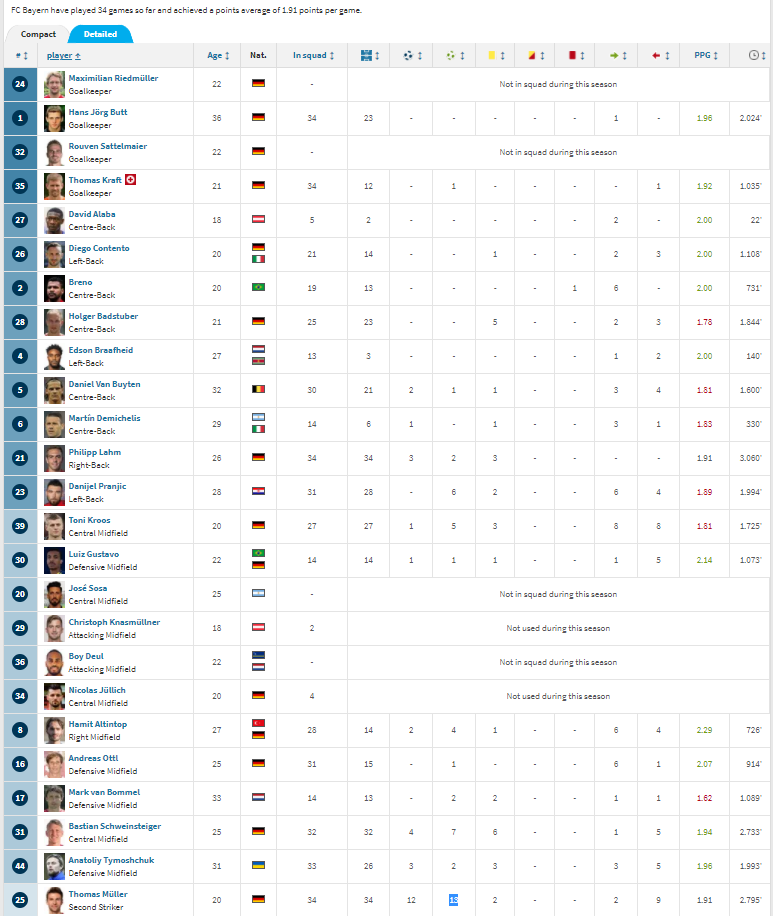" />


### Fbref

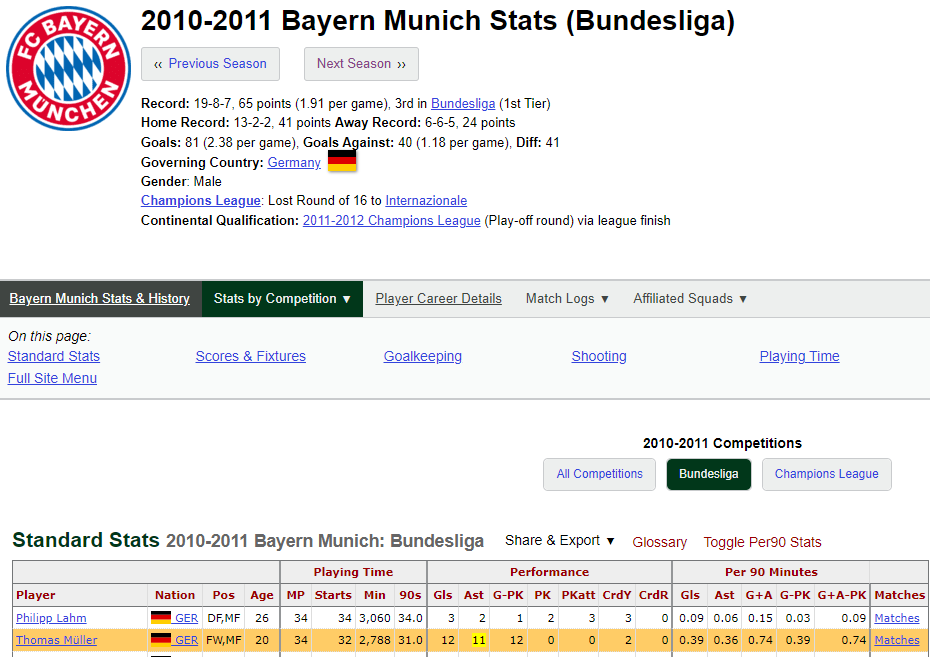


This is truly unfortunate as I can't verify which value is actually right for each instance.

I will say that since transfermarkt is a german websit, maybe they are more reliable with their sources and will therefore use that data as the 'truth'.

Now the data shoudld be prepared for merging.

## Robust Datapipline and Merging

First, the fbref dataframes will be modified and prepared for merging. I will use variable names like df2,df3  etc. to  not overwrite the original dataframe and for  each  step of preprocessing, I will change  the dataframe variable again, so  each process is done on 1 dataframe. This might seem confusing at frist, but it actually makes it easier to understand when which changes and processes are applied to the dataframes in order to clean and prepare them. While variable names like df2 are verbose and meaningless, after processecing is done, the dataframes will have reasonable names, like 'stats_fcb'.

### Preparing for merging

In [359]:
# to not overwrite the original scraped dataframes, copies will be made, before I apply any changes to the dataframe
df2 = fbref_fcb.copy(deep=True)
df3 = fbref_bvb.copy(deep=True)

In [360]:
# Prepare for merging by adjusting column names or removing them

# adding the season column to the fbref dataframe
df2["club"]  = ["Bayern Munich" for x in fbref_fcb["season"]]
df3["club"]  = ["Borussia Dortmund" for x in fbref_bvb["season"]]

#channing column name pos into position_adv to match fbref df with transfermarkt df column name
df2.columns = ['position_adv' if x=='pos' else x for x in df2.columns]
df3.columns = ['position_adv' if x=='pos' else x for x in df3.columns]


# removing goals column from fbref  df's
df2.drop('gls', axis=1, inplace=True)
df3.drop('gls', axis=1, inplace=True)

# removing ast column from fbref  df's
df2.drop('ast', axis=1, inplace=True)
df3.drop('ast', axis=1, inplace=True)

# removing age column from fbref  df's
df2.drop('age', axis=1, inplace=True)
df3.drop('age', axis=1, inplace=True)

# removing crdY column from fbref  df's
df2.drop('crdY', axis=1, inplace=True)
df3.drop('crdY', axis=1, inplace=True)

# removing crdR column from fbref  df's
df2.drop('crdR', axis=1, inplace=True)
df3.drop('crdR', axis=1, inplace=True)


# removing mp column from fbref  df's
df2.drop('mp', axis=1, inplace=True)
df3.drop('mp', axis=1, inplace=True)

# removing club column from fbref  df's
df2.drop('club', axis=1, inplace=True)
df3.drop('club', axis=1, inplace=True)

# removing minutes column from fbref  df's
df2.drop('minutes', axis=1, inplace=True)
df3.drop('minutes', axis=1, inplace=True)


###  seperating the players dataframe by  club and preparing it for merging

In [361]:
# copy the original dataframe to leave the original unchanged in case I need the original later on
df4 = players.copy()

# replacing every '-' in players df with '0'
df4 = df4.replace(to_replace='-',value=0)

# stripping last character of each entry in minutes played column via lambda function
df4['minutes_played'] = df4['minutes_played'].map(lambda x: str(x)[:-1])

# replacing every '' in players df with '0'
df4 = df4.replace(to_replace='',value=0)

# converting every entry  in minutes column to string via lambda function
df4['minutes_played'] = df4['minutes_played'].map(lambda x: str(x))

# removing  punctuation in every string of minutes_played column via lambda function
df4['minutes_played'] = df4['minutes_played'].map(lambda x: x.replace(',', ''))
df4['minutes_played'] = df4['minutes_played'].map(lambda x: x.replace('.', ''))

# using pandas convert_dtypes to onvert columns to best possible dtypes 
df4.convert_dtypes()

# convertering several columns to proper datatypes using the to_numeric function
df4[["in_squad","appearances","goals","assists","yellow_cards","second_yellow_cards","red_cards","substitutions_on","substitutions_off"]] = df4[["in_squad","appearances","goals","assists","yellow_cards","second_yellow_cards","red_cards","substitutions_on","substitutions_off"]].apply(pd.to_numeric)

In [362]:
# seperating players df by club
df5 = df4.groupby(['club'])
df6 = df4.groupby(['club'])

In [363]:
# getting groubby objects
df5 = df5.get_group(('Bayern Munich'))
df6 = df6.get_group(('Borussia Dortmund'))

Great  so  now  we have df2  and  df3 which are the fbref dfs for fcb and bvb df.

And we have df5 and  df6 which are the transfermarkt(players) df  for  fcb and bvb.

But the  players df's(5 and 6) are bigger  than the fbref ones.

While trying  to merge on name it would leave out the names which were not in players and fbref dataframe.

Thats why I need to add the missing names to the fbref(df4) dataframe

### Adding missing names

Adding missing names to fcb df

In [364]:
#getting  set  of each name column
a= list(df5.name)
a = set(a)
b = list(df2.name)
b = set(b)


#getting  list of missing name
missing_names=[]
for name in a:
    if name not in b:
        missing_names.append(str(name))
        
#appending  rows of missing names and 0 values to df4 which was the fbref  copy
for name in  missing_names:
    add_names=[]
    add_names.append(name)
    add_names.append(0)
    add_names.append(0)
    add_names.append(0)
    add_names.append(0)
    add_names.append(0)
    add_names.append(2010)
    names_fcb_df=pd.DataFrame(add_names)
    names_fcb_df=names_fcb_df.transpose()
    names_fcb_df.columns=list(df2.columns)
    df2=df2.append(names_fcb_df, ignore_index=True)

Adding  missing  names to bvb df

In [365]:
#getting  set  of each name column
a= list(df6.name)
a = set(a)
b = list(df3.name)
b = set(b)


#getting  list of missing name
missing_names=[]
for name in a:
    if name not in b:
        missing_names.append(str(name))
        
#appending  rows of missing names and 0 values to df4 which was the fbref  copy
for name in  missing_names:
    add_names=[]
    add_names.append(name)
    add_names.append(0)
    add_names.append(0)
    add_names.append(0)
    add_names.append(0)
    add_names.append(0)
    add_names.append(2010)
    names_bvb_df=pd.DataFrame(add_names)
    names_bvb_df=names_bvb_df.transpose()
    names_bvb_df.columns=list(df3.columns)
    df3=df3.append(names_bvb_df, ignore_index=True)

In [366]:
# merging fcb dfs  and  bvb dfs
merged_fcb = pd.merge(df5,df2,on=['name','season'],how='outer')
merged_bvb = pd.merge(df6,df3,on=['name','season'],how='outer')

In [367]:
# Error cheking: test if merged right
x  = df2.groupby(['name','season']).get_group(('Thomas Müller',2010))
x  = int(x.g_pk[1])
y = df5.groupby(['name','season']).get_group(('Thomas Müller',2010))
y = int(y.appearances)

a = merged_fcb.groupby(['name']).get_group('Thomas Müller')
b = int(a.appearances.iloc[0])
a = int(a.g_pk.iloc[0])

if b == y and a ==x:
       print('Merging was successful!')

Merging was successful!


Awesome, mergning was successful!

Now the merged dataframe  needs to be  cleaned.

### cleaning merged dataframes

In [368]:
# 'removing' every row, where club column is NA
merged_fcb = merged_fcb[merged_fcb['club'].notna()]
merged_bvb= merged_bvb[merged_bvb['club'].notna()]

# filling nan values,which were a result of merging, with 0s
merged_fcb = merged_fcb.fillna(0)
merged_bvb = merged_bvb.fillna(0)

# replacing every '0' in position_adv column df with ''
merged_fcb['position_adv'] = merged_fcb['position_adv'].replace(to_replace=0,value='')
merged_bvb['position_adv'] = merged_bvb['position_adv'].replace(to_replace=0,value='')

# replacing every '0' in info column df with ''
merged_fcb['info'] = merged_fcb['info'].replace(to_replace=0,value='')
merged_bvb['info'] = merged_bvb['info'].replace(to_replace=0,value='')

# adjusting the order  of the columns
merged_fcb = merged_fcb[['club', 'name', 'age', 'position','position_adv','in_squad','appearances','goals','assists','g_pk','PK','PKatt','yellow_cards','second_yellow_cards','red_cards','substitutions_on','substitutions_off','minutes_played','info','season']]
merged_bvb = merged_bvb[['club', 'name', 'age', 'position','position_adv','in_squad','appearances','goals','assists','g_pk','PK','PKatt','yellow_cards','second_yellow_cards','red_cards','substitutions_on','substitutions_off','minutes_played','info','season']]

In [369]:
#checking the dtypes for the df, almost all of them are not ideal
print(merged_fcb.dtypes)

club                    object
name                    object
age                     object
position                object
position_adv            object
in_squad               float64
appearances            float64
goals                  float64
assists                float64
g_pk                    object
PK                      object
PKatt                   object
yellow_cards           float64
second_yellow_cards    float64
red_cards              float64
substitutions_on       float64
substitutions_off      float64
minutes_played          object
info                    object
season                 float64
dtype: object


In [370]:
# using pandas convert_dtypes to onvert columns to best possible dtypes 
merged_fcb=merged_fcb.convert_dtypes()
merged_bvb=merged_bvb.convert_dtypes()
print(merged_fcb.dtypes)

club                   string
name                   string
age                    string
position               string
position_adv           string
in_squad                Int64
appearances             Int64
goals                   Int64
assists                 Int64
g_pk                   object
PK                     object
PKatt                  object
yellow_cards            Int64
second_yellow_cards     Int64
red_cards               Int64
substitutions_on        Int64
substitutions_off       Int64
minutes_played         string
info                   string
season                  Int64
dtype: object


In [371]:
# convertering several columns to proper datatypes using the to_numeric function

merged_bvb[['in_squad','appearances','goals','assists','g_pk','PK','PKatt','yellow_cards','second_yellow_cards','red_cards','substitutions_on','substitutions_off','minutes_played']] = merged_bvb[['in_squad','appearances','goals','assists','g_pk','PK','PKatt','yellow_cards','second_yellow_cards','red_cards','substitutions_on','substitutions_off','minutes_played']].apply(pd.to_numeric)
merged_fcb[['in_squad','appearances','goals','assists','g_pk','PK','PKatt','yellow_cards','second_yellow_cards','red_cards','substitutions_on','substitutions_off','minutes_played']] = merged_fcb[['in_squad','appearances','goals','assists','g_pk','PK','PKatt','yellow_cards','second_yellow_cards','red_cards','substitutions_on','substitutions_off','minutes_played']].apply(pd.to_numeric)

In [372]:
print(merged_fcb.dtypes)

club                   string
name                   string
age                    string
position               string
position_adv           string
in_squad                Int64
appearances             Int64
goals                   Int64
assists                 Int64
g_pk                    int64
PK                      int64
PKatt                   int64
yellow_cards            Int64
second_yellow_cards     Int64
red_cards               Int64
substitutions_on        Int64
substitutions_off       Int64
minutes_played          int64
info                   string
season                  Int64
dtype: object


In [373]:
stats_fcb_original = merged_fcb.copy(deep=True)
stats_bvb_original = merged_bvb.copy(deep=True)
display(merged_fcb)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
0,Bayern Munich,Maximilian Riedmüller,22,Goalkeeper,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2010
1,Bayern Munich,Hans Jörg Butt,36,Goalkeeper,,34,23,0,0,0,0,0,0,0,0,1,0,2024,,2010
2,Bayern Munich,Rouven Sattelmaier,22,Goalkeeper,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2010
3,Bayern Munich,Thomas Kraft,21,Goalkeeper,GK,34,12,0,1,0,0,0,0,0,0,0,1,1035,,2010
4,Bayern Munich,David Alaba,18,Centre-Back,"DF,MF",5,2,0,0,0,0,0,0,0,0,2,0,22,,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,Bayern Munich,Eric Maxim Choupo-Moting,31,Centre-Forward,"FW,MF",29,22,3,0,3,0,0,2,0,0,14,4,810,,2020
367,Bayern Munich,Leon Dajaku,19,Second Striker,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2020
368,Bayern Munich,Armindo Sieb,17,Second Striker,FW,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2020
369,Bayern Munich,Fiete Arp,20,Centre-Forward,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2020


Now that looks like a properly cleaned and merged dataframe!

So this was the first goal for data preprocessing: 2 dataframes for each club with merged player statistic.

Now onto the transfers dataframe!

### Preprocessing the transfers  dataframe

In [374]:
# checking if manually curated lists is subset of first and last row of transfers df  
check_list_first = ['Bayern Munich','in','Luiz Gustavo','2010']
actual_list_first = transfers.iloc[0].values.tolist()
actual_list_first = [str(x) for x in actual_list_first]
check_list_last = ['Borussia Dortmund','out','Emre Can','2020']
actual_list_last = transfers.iloc[-1].values.tolist()
actual_list_last = [str(x) for x in actual_list_last]

if set(check_list_first).issubset(actual_list_first) and set(check_list_last).issubset(actual_list_last) == True:
    print('Transfers have sucessfully been scraped')

Transfers have sucessfully been scraped


In [375]:
# to not overwrite the original scraped dataframes, copies will be made, before I apply any changes to the dataframe
df7 = transfers.copy(deep=True)

In [376]:
# checking for any missing values in the transfers df
print(df7.isnull().values.any())

False


In [377]:
df7.dtypes

club            object
direction       object
name            object
age             object
position        object
market_value    object
left_joined     object
fee             object
season           int64
dtype: object

In [378]:
# using pandas convert_dtypes to onvert columns to best possible dtypes 
df7 = df7.convert_dtypes()
df7.dtypes

club            string
direction       string
name            string
age             string
position        string
market_value    string
left_joined     string
fee             string
season           Int64
dtype: object

In [379]:
#  the goal is to have 2 readable  columns of fee and market value and 2 cleaned ones ready for math or other use cases
#copying values of fee column into new 'info' column
df7['info/fee']=df7['fee']
#copying values of fee column into new 'info' column
df7['value'] = df7['market_value']

# replacing '-' with '0' in market value and fee columns
df7['market_value'] = df7['market_value'].map(lambda x: str(x).replace('-', '00'))
df7['fee'] = df7['fee'].map(lambda x: str(x).replace('-', '00'))

# removing '£' sign from market value string
df7['market_value'] = df7['market_value'].map(lambda x: str(x)[1:])

# removing '.' from market value string
df7['market_value'] = df7['market_value'].map(lambda x: str(x).replace('.', ''))

# replacing 'm' with six '0' market value string
df7['market_value'] = df7['market_value'].map(lambda x: str(x).replace('m', '0000'))

# replacing 'Th' with three '0' market value string
df7['market_value'] = df7['market_value'].map(lambda x: str(x).replace('Th', '000'))

# applying same lambda function to fee column
# removing first character  from fee string
df7['fee'] = df7['fee'].map(lambda x: str(x)[1:])

# removing '.' from fee string
df7['fee'] = df7['fee'].map(lambda x: str(x).replace('.', ''))

# replacing 'm' with 4 '0' from fee string
df7['fee'] = df7['fee'].map(lambda x: str(x).replace('m', '0000'))

# replacing 'Th' with three '0' from fee string
df7['fee'] = df7['fee'].map(lambda x: str(x).replace('Th', '000'))

# replacing 'o' with one '0' from fee string
df7['fee'] = df7['fee'].map(lambda x: str(x).replace(' fee', '0'))

# replacing 'loan' with one '0' from fee string
df7['fee'] = df7['fee'].map(lambda x: str(x).replace('loan', '0'))

# replacing ' transfer' with one '0' from fee string
df7['fee'] = df7['fee'].map(lambda x: str(x).replace('transfer', '0'))

# removing non digit characters from fee string
df7['fee'] = df7['fee'].map(lambda x: ''.join(c for c in str(x) if c.isdigit()))

# chaning column order
df7 = df7[['club','direction','name','age','position','left_joined','value','info/fee','fee','market_value','season']]

In [380]:
# chaning info values to promoted/demoted if direction is in/out and no info is given
df7.loc[(df7['info/fee']=='-')  & (df7['direction'] == 'in'),'info/fee'] = "promoted"
df7.loc[(df7['info/fee']=='-')  & (df7['direction'] == 'out'),'info/fee'] = "demoted"

In [381]:
# convertering market value and fee column to numeric data types
df7[['market_value',"fee","age"]]= df7[['market_value',"fee","age"]].apply(pd.to_numeric) 

In [382]:
# chaning info values to promoted/demoted if direction is in/out and no info is given
#df7.loc[(df7['value']=='-') ,'market_value'] = "-"

In [383]:
# chaning info values to promoted/demoted if direction is in/out and no info is given
df7.loc[(df7['info/fee']=='End of loan')  & (df7['direction'] == 'in'),'info/fee'] = "returned from loan"
df7.loc[(df7['info/fee']=='End of loan')  & (df7['direction'] == 'out'),'info/fee'] = "loaned away"

In [384]:
df7[['fee']] = df7[['fee']].fillna(0)
df7[['fee']]  = df7[['fee']].astype(int)
df7[['market_value']]  = df7[['market_value']].astype(int)

In [385]:
# checking dtypes for transfers df
df7.dtypes

club            string
direction       string
name            string
age              int64
position        string
left_joined     string
value           string
info/fee        string
fee              int32
market_value     int32
season           Int64
dtype: object

Even though the fees column had information about loans, I overwrote the data frame with 0s if there were no numbers in the string. The information about whether a player is loaned or not is useless without knowing his salary. And since this project focuses on transfer policy and not on all the financials of the clubs, only knowing the transfer fees is sufficient for now.

Now the transfers data needs to be seperated by club.

In [386]:
# seperating transfers df by club
df8 = df7.groupby(['club'])
df9 = df7.groupby(['club'])

In [387]:
# getting groubby objects
df8 = df8.get_group(('Bayern Munich'))
df9 = df9.get_group(('Borussia Dortmund'))

In [388]:
transfers_fcb_original  = df8.copy(deep=True)
transfers_bvb_original  = df9.copy(deep=True)

In [389]:
display(transfers_fcb_original)

,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,Bayern Munich,in,Luiz Gustavo,23,Defensive Midfield,TSG Hoffenheim,£2.16m,£15.30m,15300000,2160000,2010
1,Bayern Munich,in,David Alaba,18,Centre-Back,FC Bayern II,£49.50m,promoted,0,49500000,2010
2,Bayern Munich,in,José Sosa,25,Central Midfield,Estudiantes,£810Th.,returned from loan,0,810000,2010
3,Bayern Munich,in,Luca Toni,33,Centre-Forward,AS Roma,-,returned from loan,0,0,2010
4,Bayern Munich,in,Breno,20,Centre-Back,1.FC Nuremberg,£180Th.,returned from loan,0,180000,2010
...,...,...,...,...,...,...,...,...,...,...,...
443,Bayern Munich,out,Fiete Arp,20,Centre-Forward,FC Bayern II,£450Th.,demoted,0,450000,2020
444,Bayern Munich,out,Douglas Costa,30,Right Winger,Juventus,£3.60m,loaned away,0,3600000,2020
445,Bayern Munich,out,Álvaro Odriozola,24,Right-Back,Real Madrid,£11.70m,loaned away,0,11700000,2020
446,Bayern Munich,out,Philippe Coutinho,28,Left Winger,Barcelona,£16.20m,loaned away,0,16200000,2020


Now that the data has been cleaned and processed, there are 4 dataframes available for further analysis:

    1.transfers_fcb_original: containing all dataframes for FCB from 2010-2020, data from transfermarkt.
    2.transfers_bvb_original: containing all dataframes for BVB from 2010-2020, data from transfermarkt.
    3.stats_fcb_original: containing all player statistics for FCB from 2010-2020, data from transfermarkt and fbref.
    3.stats_bvb_original: containing all player statistics for FCB from 2010-2020, data from transfermarkt and fbref.

#  Analysis


### How do FCB and BVB approach their transfer strategy? Are they buying well-known superstars for a lot of money or are they taking their chances with cheaper rookies?

### Has their approach changes over the years or e.g., after not winning the league?

to not overwrite the transfers  dataframe, I will copy it  and carry out  the analysis  on   said copy.

In [390]:
# copying original dataframes,  to not overwrite or mutate them in any way
transfers_fcb = transfers_fcb_original.copy(deep=True)
transfers_bvb = transfers_bvb_original.copy(deep=True)
stats_fcb  = stats_fcb_original.copy(deep=True)
stats_bvb  = stats_bvb_original.copy(deep=True)

In [391]:
# function for showing relevant df
def show_transfers(df1,df2,season):
    df1 = df1.groupby(['direction','season']).get_group(('in',season)).reset_index()
    df2 = df2.groupby(['direction','season']).get_group(('in',season)).reset_index()
    return display(df1,df2)

In [392]:
# function for adding commas to big numbers
# source: https://stackoverflow.com/questions/1823058/how-to-print-number-with-commas-as-thousands-separators
def intWithCommas(x):
    if type(x) not in [type(0)]:
        raise TypeError("Parameter must be an integer.")
    if x < 0:
        return '-' + intWithCommas(-x)
    result = ''
    while x >= 1000:
        x, r = divmod(x, 1000)
        result = ",%03d%s" % (r, result)
    return "%d%s" % (x, result)

# function for getting  relevant  info of given season for both clubs from transfers df
# no return statement needed, otherwise it would print and return None too
def get_info(df1,df2,season):
    total_fee1 = sum(list(df1.groupby(['direction','season']).get_group(('in',season)).fee))
    total_fee2 = sum(list(df2.groupby(['direction','season']).get_group(('in',season)).fee))
    market_value1  = sum(list(df1.groupby(['direction','season']).get_group(('in',season)).market_value))
    market_value2 = sum(list(df2.groupby(['direction','season']).get_group(('in',season)).market_value))
    amount1 = len(df1.groupby(['direction','season']).get_group(('in',season)))
    amount2 = len(df2.groupby(['direction','season']).get_group(('in',season)))
    bought1= df1.groupby(['direction','season']).get_group(('in',season)).loc[df1.groupby(['direction','season']).get_group(('in',season))['fee'] != 0, 'fee'].count()
    bought2= df2.groupby(['direction','season']).get_group(('in',season)).loc[df2.groupby(['direction','season']).get_group(('in',season))['fee'] != 0, 'fee'].count()
    average_Age1=round(sum(list(df1.groupby(['direction','season']).get_group(('in',season)).age))/len(df1.groupby(['direction','season']).get_group(('in',season)).age),2)
    average_Age2=round(sum(list(df2.groupby(['direction','season']).get_group(('in',season)).age))/len(df2.groupby(['direction','season']).get_group(('in',season)).age),2)
    count_promoted1=df1.groupby(['direction','season']).get_group(('in',season)).loc[df1.groupby(['direction','season']).get_group(('in',season))['info/fee'] == 'promoted', 'info/fee'].count()
    count_promoted2=df2.groupby(['direction','season']).get_group(('in',season)).loc[df2.groupby(['direction','season']).get_group(('in',season))['info/fee'] == 'promoted', 'info/fee'].count()
    if total_fee1 > total_fee2:
        difference  = total_fee1-total_fee2
        total_fee1=intWithCommas(total_fee1)
        total_fee2=intWithCommas(total_fee2)
        market_value1=intWithCommas(market_value1)
        market_value2=intWithCommas(market_value2)
        difference = intWithCommas(difference)
        
        print('FCB bought '+str(bought1)+' players for a total of: '+str(total_fee1)+'£.')
        print('FCB acquired '+str(amount1)+' players for a total of: '+str(market_value1)+'£ in current market value.')
        print('BVB bought '+str(bought2)+' players for a total of: '+str(total_fee2)+'£.')
        print('BVB acquired '+str(amount2)+' players for a total of: '+str(market_value2)+'£ in current market value.')
        print('FCB spent '+str(difference)+'£ more on new players than BVB this season.')
        print('The average age of new/returning  players for FCB was '+str(average_Age1)+'.')
        print('The average age of new/returning  players for BVB was '+str(average_Age2)+'.')
        print('FCB promoted '+str(count_promoted1)+' player(s), while BVB promoted '+str(count_promoted2)+' player(s).')
    else: 
        difference  = total_fee2-total_fee1
        total_fee1=intWithCommas(total_fee1)
        total_fee2=intWithCommas(total_fee2)
        market_value1=intWithCommas(market_value1)
        market_value2=intWithCommas(market_value2)
        difference = intWithCommas(difference)
        print('FCB bought '+str(bought1)+' players for a total of: '+str(total_fee1)+'£.')
        print('FCB acquired '+str(amount1)+' players for a total of: '+str(market_value1)+'£ in current market value.')
        print('BVB bought '+str(bought2)+' players for a total of: '+str(total_fee2)+'£.')
        print('BVB acquired '+str(amount2)+' players for a total of: '+str(market_value2)+'£ in current market value.')
        print('BVB spent '+str(difference)+'£ more on new players than FCB this season.')
        print('The average age of new/returning players for FCB was '+str(average_Age1)+'.')
        print('The average age of new/returning  players for BVB was '+str(average_Age2)+'.')
        print('FCB promoted '+str(count_promoted1)+' player(s), while BVB promoted '+str(count_promoted2)+' player(s).')

# get names of new players for each season
def get_names(df1,df2,season):
    names_fcb = df1.groupby(['direction','season']).get_group(('in',season)).name
    names_bvb = df2.groupby(['direction','season']).get_group(('in',season)).name
    return names_fcb,names_bvb
# function for displaying stats df for relevant season, but only showing newly acquirred players, to see if they were used from the get go
def stats_new_players(df1,df2,season):
    names_fcb,names_bvb = get_names(df1,df2,season)
    display(stats_fcb.groupby('season').get_group(season).loc[stats_fcb.groupby('season').get_group(season)['name'].isin(names_fcb)])
    display(stats_bvb.groupby('season').get_group(season).loc[stats_bvb.groupby('season').get_group(season)['name'].isin(names_bvb)])


### Season 2010/11

In [393]:
show_transfers(transfers_fcb,transfers_bvb,2010)
get_info(transfers_fcb,transfers_bvb,2010)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,0,Bayern Munich,in,Luiz Gustavo,23,Defensive Midfield,TSG Hoffenheim,£2.16m,£15.30m,15300000,2160000,2010
1,1,Bayern Munich,in,David Alaba,18,Centre-Back,FC Bayern II,£49.50m,promoted,0,49500000,2010
2,2,Bayern Munich,in,José Sosa,25,Central Midfield,Estudiantes,£810Th.,returned from loan,0,810000,2010
3,3,Bayern Munich,in,Luca Toni,33,Centre-Forward,AS Roma,-,returned from loan,0,0,2010
4,4,Bayern Munich,in,Breno,20,Centre-Back,1.FC Nuremberg,£180Th.,returned from loan,0,180000,2010
5,5,Bayern Munich,in,Andreas Ottl,25,Defensive Midfield,1.FC Nuremberg,-,returned from loan,0,0,2010
6,6,Bayern Munich,in,Edson Braafheid,27,Left-Back,Celtic,-,returned from loan,0,0,2010
7,7,Bayern Munich,in,Toni Kroos,20,Central Midfield,Bay. Leverkusen,£22.50m,returned from loan,0,22500000,2010


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,18,Borussia Dortmund,in,Robert Lewandowski,21,Centre-Forward,Lech Poznan,£45.00m,£4.28m,4280000,45000000,2010
1,19,Borussia Dortmund,in,Mitchell Langerak,21,Goalkeeper,Melbourne,£810Th.,£450Th.,450000,810000,2010
2,20,Borussia Dortmund,in,Moritz Leitner,18,Central Midfield,1860 Munich,£540Th.,free transfer,0,540000,2010
3,21,Borussia Dortmund,in,Antônio da Silva,32,Attacking Midfield,Karlsruher SC,-,free transfer,0,0,2010
4,22,Borussia Dortmund,in,Lukasz Piszczek,25,Right-Back,Hertha BSC,-,free transfer,0,0,2010
5,23,Borussia Dortmund,in,Shinji Kagawa,21,Attacking Midfield,Cerezo Osaka,£1.08m,free transfer,0,1080000,2010
6,24,Borussia Dortmund,in,Lasse Sobiech,19,Centre-Back,B. Dortmund II,£630Th.,promoted,0,630000,2010
7,25,Borussia Dortmund,in,Marco Stiepermann,19,Attacking Midfield,B. Dortmund U19,£405Th.,promoted,0,405000,2010
8,26,Borussia Dortmund,in,Daniel Ginczek,19,Centre-Forward,B. Dortmund II,£900Th.,promoted,0,900000,2010
9,27,Borussia Dortmund,in,Mario Götze,18,Attacking Midfield,B. Dortmund U19,£10.80m,promoted,0,10800000,2010


FCB bought 1 players for a total of: 15,300,000£.
FCB acquired 8 players for a total of: 75,150,000£ in current market value.
BVB bought 2 players for a total of: 4,730,000£.
BVB acquired 12 players for a total of: 60,165,000£ in current market value.
FCB spent 10,570,000£ more on new players than BVB this season.
The average age of new/returning  players for FCB was 23.88.
The average age of new/returning  players for BVB was 21.67.
FCB promoted 1 player(s), while BVB promoted 5 player(s).


Wow, ok. 3 things immidiatly come to mind when looking at the transfers of both teams:

    1.BVB got way more players than FCB in this offeason(4 more players).
    2.BVB promoted a lot of young talent from  their second division or even their youth divison(5 in total)
    3.BVB got younger players than FCB.
    
Just for clarity: in the transfers dataframe, transfermarkt always used the current market value of a player at the time of scraping, instead of the market value, that the players had back in the time. E.g. season 2010/2011 BVB bought Lewandowski for ~ 5 million £ but the df states he has a market value of 45 million£. The historic market value back for a player in past seasons was roughly  the same as the fees paid. So the market value column gives a pretty good indicaiton about the progress and value gains/losses of a player and the info/fees column gives us an idea of the past market_value/fees the club had to pay.

### Season 2011/12

In [394]:
show_transfers(transfers_fcb,transfers_bvb,2011)
get_info(transfers_fcb,transfers_bvb,2011)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,42,Bayern Munich,in,Manuel Neuer,25,Goalkeeper,FC Schalke 04,£12.60m,£27.00m,27000000,12600000,2011
1,43,Bayern Munich,in,Jérôme Boateng,22,Centre-Back,Man City,£4.50m,£12.15m,12150000,4500000,2011
2,44,Bayern Munich,in,Rafinha,25,Right-Back,Genoa,£540Th.,£4.95m,4950000,540000,2011
3,45,Bayern Munich,in,Nils Petersen,22,Centre-Forward,Energie Cottbus,£1.62m,£2.52m,2520000,1620000,2011
4,46,Bayern Munich,in,Takashi Usami,19,Centre-Forward,Gamba Osaka,£990Th.,Loan fee:,0,990000,2011
5,47,Bayern Munich,in,Maximilian Riedmüller,23,Goalkeeper,FC Bayern II,£45Th.,promoted,0,45000,2011
6,48,Bayern Munich,in,Mehmet Ekici,21,Attacking Midfield,1.FC Nuremberg,£135Th.,returned from loan,0,135000,2011
7,49,Bayern Munich,in,David Alaba,19,Centre-Back,TSG Hoffenheim,£49.50m,returned from loan,0,49500000,2011


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,55,Borussia Dortmund,in,Ilkay Gündogan,20,Central Midfield,1.FC Nuremberg,£31.50m,£4.95m,4950000,31500000,2011
1,56,Borussia Dortmund,in,Ivan Perisic,22,Left Midfield,Club Brugge,£9.00m,£3.60m,3600000,9000000,2011
2,57,Borussia Dortmund,in,Chris Löwe,22,Left-Back,Chemnitzer FC,£270Th.,£203Th.,203000,270000,2011
3,58,Borussia Dortmund,in,Marvin Bakalorz,21,Defensive Midfield,B. Dortmund II,£270Th.,promoted,0,270000,2011
4,59,Borussia Dortmund,in,Julian Koch,20,Defensive Midfield,MSV Duisburg,-,returned from loan,0,0,2011
5,60,Borussia Dortmund,in,Dimitar Rangelov,28,Second Striker,M. Tel Aviv,-,returned from loan,0,0,2011
6,61,Borussia Dortmund,in,Tamás Hajnal,30,Attacking Midfield,VfB Stuttgart,-,returned from loan,0,0,2011
7,62,Borussia Dortmund,in,Moritz Leitner,18,Central Midfield,FC Augsburg,£540Th.,returned from loan,0,540000,2011


FCB bought 4 players for a total of: 46,620,000£.
FCB acquired 8 players for a total of: 69,930,000£ in current market value.
BVB bought 3 players for a total of: 8,753,000£.
BVB acquired 8 players for a total of: 41,580,000£ in current market value.
FCB spent 37,867,000£ more on new players than BVB this season.
The average age of new/returning  players for FCB was 22.0.
The average age of new/returning  players for BVB was 22.62.
FCB promoted 1 player(s), while BVB promoted 1 player(s).


FCB spent almost 40 million more on transfers that season. That is a lot. But for that money they acquired Manuel Neuer, who later became their team leader and the worlds best goalkeeper. They also got Jerome Boateng who stayed for almost a decade at FCB and was the foundation of a strong defence.

### Season 2012/13

In [395]:
show_transfers(transfers_fcb,transfers_bvb,2012)
get_info(transfers_fcb,transfers_bvb,2012)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,74,Bayern Munich,in,Javi Martínez,23,Defensive Midfield,Athletic,£3.60m,£36.00m,36000000,3600000,2012
1,75,Bayern Munich,in,Mario Mandzukic,26,Centre-Forward,VfL Wolfsburg,-,£11.70m,11700000,0,2012
2,76,Bayern Munich,in,Xherdan Shaqiri,20,Right Winger,FC Basel,£7.20m,£10.62m,10620000,7200000,2012
3,77,Bayern Munich,in,Dante,28,Centre-Back,Bor. M'gladbach,£900Th.,£4.23m,4230000,900000,2012
4,78,Bayern Munich,in,Mitchell Weiser,18,Right-Back,1.FC Köln U19,£1.35m,£720Th.,720000,1350000,2012
5,79,Bayern Munich,in,Lukas Raeder,18,Goalkeeper,Schalke 04 U19,£203Th.,free transfer,0,203000,2012
6,80,Bayern Munich,in,Tom Starke,31,Goalkeeper,TSG Hoffenheim,-,free transfer,0,0,2012
7,81,Bayern Munich,in,Claudio Pizarro,33,Centre-Forward,Werder Bremen,-,free transfer,0,0,2012
8,82,Bayern Munich,in,Patrick Weihrauch,18,Attacking Midfield,FC Bayern U19,£360Th.,promoted,0,360000,2012
9,83,Bayern Munich,in,Emre Can,18,Defensive Midfield,FC Bayern II,£14.40m,promoted,0,14400000,2012


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,91,Borussia Dortmund,in,Marco Reus,23,Attacking Midfield,Bor. M'gladbach,£11.70m,£15.39m,15390000,11700000,2012
1,92,Borussia Dortmund,in,Julian Schieber,23,Centre-Forward,VfB Stuttgart,-,£4.95m,4950000,0,2012
2,93,Borussia Dortmund,in,Leonardo Bittencourt,18,Attacking Midfield,Energie Cottbus,£3.15m,£2.43m,2430000,3150000,2012
3,94,Borussia Dortmund,in,Nuri Sahin,24,Defensive Midfield,Real Madrid,-,Loan fee:,0,0,2012
4,95,Borussia Dortmund,in,Oliver Kirch,29,Defensive Midfield,1.FC K'lautern,-,£315Th.,315000,0,2012
5,96,Borussia Dortmund,in,Koray Günter,17,Centre-Back,B. Dortmund U19,£4.50m,promoted,0,4500000,2012
6,97,Borussia Dortmund,in,Zlatan Alomerovic,21,Goalkeeper,B. Dortmund II,£315Th.,promoted,0,315000,2012
7,98,Borussia Dortmund,in,Marc Hornschuh,21,Centre-Back,FC Ingolstadt,£180Th.,returned from loan,0,180000,2012
8,99,Borussia Dortmund,in,Dimitar Rangelov,29,Second Striker,Energie Cottbus,-,returned from loan,0,0,2012
9,100,Borussia Dortmund,in,Daniel Ginczek,21,Centre-Forward,VfL Bochum,£900Th.,returned from loan,0,900000,2012


FCB bought 5 players for a total of: 63,270,000£.
FCB acquired 10 players for a total of: 28,013,000£ in current market value.
BVB bought 4 players for a total of: 23,085,000£.
BVB acquired 12 players for a total of: 21,780,000£ in current market value.
FCB spent 40,185,000£ more on new players than BVB this season.
The average age of new/returning  players for FCB was 23.3.
The average age of new/returning  players for BVB was 22.33.
FCB promoted 2 player(s), while BVB promoted 2 player(s).


Bayern has spent more again, back in the time Javi Martinez was the most expensive transfers in the history of the Bundesliga. He also became a key-player for FCB. At BVB Marco Reus was  acquired. He was playing phenomenal at Gladbach and became the captain and team leader of BVB later on. Interesting is that  BVB seems to buy players  from smaller Bundesliga clubs and smallers clubs from forgein leagues while FCB buys their best players from bigger clubs like Man City or Athletic.

### Season 2013/14

In [396]:
show_transfers(transfers_fcb,transfers_bvb,2013)
get_info(transfers_fcb,transfers_bvb,2013)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,115,Bayern Munich,in,Mario Götze,21,Attacking Midfield,Bor. Dortmund,£10.80m,£33.30m,33300000,10800000,2013
1,116,Bayern Munich,in,Thiago,22,Central Midfield,Barcelona,£19.80m,£22.50m,22500000,19800000,2013
2,117,Bayern Munich,in,Jan Kirchhoff,22,Centre-Back,1.FSV Mainz 05,-,free transfer,0,0,2013
3,118,Bayern Munich,in,Alessandro Schöpf,19,Central Midfield,FC Bayern II,£2.25m,promoted,0,2250000,2013
4,119,Bayern Munich,in,Pierre-Emile Höjbjerg,17,Central Midfield,FC Bayern II,£36.00m,promoted,0,36000000,2013
5,120,Bayern Munich,in,Julian Green,18,Central Midfield,FC Bayern II,£1.08m,promoted,0,1080000,2013
6,121,Bayern Munich,in,Mitchell Weiser,19,Right-Back,1.FC K'lautern,£1.35m,returned from loan,0,1350000,2013
7,122,Bayern Munich,in,Nils Petersen,24,Centre-Forward,Werder Bremen,£1.62m,returned from loan,0,1620000,2013


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,130,Borussia Dortmund,in,Henrikh Mkhitaryan,24,Attacking Midfield,Shakhtar D.,£9.00m,£24.75m,24750000,9000000,2013
1,131,Borussia Dortmund,in,Pierre-Emerick Aubameyang,24,Centre-Forward,Saint-Étienne,£13.50m,£11.70m,11700000,13500000,2013
2,132,Borussia Dortmund,in,Sokratis Papastathopoulos,25,Centre-Back,Werder Bremen,£2.70m,£8.91m,8910000,2700000,2013
3,133,Borussia Dortmund,in,Milos Jojic,21,Central Midfield,Partizan,£1.80m,£1.98m,1980000,1800000,2013
4,134,Borussia Dortmund,in,Erik Durm,21,Right-Back,B. Dortmund II,£1.80m,promoted,0,1800000,2013
5,135,Borussia Dortmund,in,Manuel Friedrich,34,Centre-Back,Without Club,-,promoted,0,0,2013
6,136,Borussia Dortmund,in,Jannik Bandowski,19,Left-Back,B. Dortmund II,£90Th.,promoted,0,90000,2013
7,137,Borussia Dortmund,in,Marvin Ducksch,19,Centre-Forward,B. Dortmund II,£3.60m,promoted,0,3600000,2013
8,138,Borussia Dortmund,in,Jonas Hofmann,20,Right Winger,B. Dortmund II,£14.40m,promoted,0,14400000,2013
9,139,Borussia Dortmund,in,Marian Sarr,18,Centre-Back,B. Dortmund U19,£68Th.,promoted,0,68000,2013


FCB bought 2 players for a total of: 55,800,000£.
FCB acquired 8 players for a total of: 72,900,000£ in current market value.
BVB bought 4 players for a total of: 47,340,000£.
BVB acquired 13 players for a total of: 48,488,000£ in current market value.
FCB spent 8,460,000£ more on new players than BVB this season.
The average age of new/returning  players for FCB was 20.25.
The average age of new/returning  players for BVB was 22.38.
FCB promoted 3 player(s), while BVB promoted 6 player(s).


The 13/14 season was a though pill to  swallow for BVB as one of their stay players in Mario Götze moved to FCB.Even though they got good money from this transfer, the damage was done. This is the first time that BVB even bought a single player for over 20 million. They were desperate to fill the hole that Götze left behind. FCB not only weakend their rival but also got a promosing player with Götze. But this is the fouth season in a row, where FCB spent more on new players than BVB. Also BVB promoted 6 players which is a lot.

### Season 2014/15

In [397]:
show_transfers(transfers_fcb,transfers_bvb,2014)
get_info(transfers_fcb,transfers_bvb,2014)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,154,Bayern Munich,in,Medhi Benatia,27,Centre-Back,AS Roma,-,£25.20m,25200000,0,2014
1,155,Bayern Munich,in,Juan Bernat,21,Left-Back,Valencia,£10.80m,£9.00m,9000000,10800000,2014
2,156,Bayern Munich,in,Xabi Alonso,32,Defensive Midfield,Real Madrid,-,£8.10m,8100000,0,2014
3,157,Bayern Munich,in,Sinan Kurt,18,Left Winger,M'gladbach II,£90Th.,£2.70m,2700000,90000,2014
4,158,Bayern Munich,in,Pepe Reina,31,Goalkeeper,Liverpool,£720Th.,£2.70m,2700000,720000,2014
5,159,Bayern Munich,in,Ivan Lucic,19,Goalkeeper,SV Ried,£630Th.,£360Th.,360000,630000,2014
6,160,Bayern Munich,in,Sebastian Rode,23,Central Midfield,E. Frankfurt,£2.25m,free transfer,0,2250000,2014
7,161,Bayern Munich,in,Robert Lewandowski,25,Centre-Forward,Bor. Dortmund,£45.00m,free transfer,0,45000000,2014
8,162,Bayern Munich,in,Gianluca Gaudino,17,Central Midfield,FC Bayern U19,£360Th.,promoted,0,360000,2014


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,173,Borussia Dortmund,in,Ciro Immobile,24,Centre-Forward,Torino,£27.00m,£16.65m,16650000,27000000,2014
1,174,Borussia Dortmund,in,Kevin Kampl,24,Central Midfield,RB Salzburg,£7.20m,£10.80m,10800000,7200000,2014
2,175,Borussia Dortmund,in,Matthias Ginter,20,Centre-Back,SC Freiburg,£21.60m,£9.00m,9000000,21600000,2014
3,176,Borussia Dortmund,in,Adrián Ramos,28,Centre-Forward,Hertha BSC,£450Th.,£8.73m,8730000,450000,2014
4,177,Borussia Dortmund,in,Shinji Kagawa,25,Attacking Midfield,Man Utd,£1.08m,£7.20m,7200000,1080000,2014
5,178,Borussia Dortmund,in,Nuri Sahin,25,Defensive Midfield,Real Madrid,-,£6.30m,6300000,0,2014
6,179,Borussia Dortmund,in,Dong-won Ji,23,Centre-Forward,FC Augsburg,£585Th.,free transfer,0,585000,2014
7,180,Borussia Dortmund,in,Hendrik Bonmann,20,Goalkeeper,B. Dortmund II,£180Th.,promoted,0,180000,2014
8,181,Borussia Dortmund,in,Jeremy Dudziak,19,Attacking Midfield,B. Dortmund II,£1.62m,promoted,0,1620000,2014


FCB bought 6 players for a total of: 48,060,000£.
FCB acquired 9 players for a total of: 59,850,000£ in current market value.
BVB bought 6 players for a total of: 58,680,000£.
BVB acquired 9 players for a total of: 59,715,000£ in current market value.
BVB spent 10,620,000£ more on new players than FCB this season.
The average age of new/returning players for FCB was 23.67.
The average age of new/returning  players for BVB was 23.11.
FCB promoted 1 player(s), while BVB promoted 2 player(s).


The 2014/15 season was a disaster for BVB. Their best striker and forward Robert Lewandowski got acquired by their rival FCB as a free transfer. Lewandwoski's contract ran out, so FCB did not have to pay any fee for him. They once more get a key player from BVB. At that time Lewandowski had a value of 30-40 million minimum.  This is the first time that BVB spent more on new players than FCB. They were desperate to find good replacments.

### Season 2015/16

In [398]:
show_transfers(transfers_fcb,transfers_bvb,2015)
get_info(transfers_fcb,transfers_bvb,2015)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,190,Bayern Munich,in,Arturo Vidal,28,Central Midfield,Juventus,£2.25m,£35.33m,35330000,2250000,2015
1,191,Bayern Munich,in,Douglas Costa,24,Right Winger,Shakhtar D.,£3.60m,£27.00m,27000000,3600000,2015
2,192,Bayern Munich,in,Joshua Kimmich,20,Defensive Midfield,VfB Stuttgart,£76.50m,£7.65m,7650000,76500000,2015
3,193,Bayern Munich,in,Kingsley Coman,19,Right Winger,Juventus,£54.00m,Loan fee:,0,54000000,2015
4,194,Bayern Munich,in,Sven Ulreich,26,Goalkeeper,VfB Stuttgart,£810Th.,£3.15m,3150000,810000,2015
5,195,Bayern Munich,in,Serdar Tasci,28,Centre-Back,Spartak Moscow,-,Loan fee:,0,0,2015
6,196,Bayern Munich,in,Jan Kirchhoff,24,Centre-Back,FC Schalke 04,-,returned from loan,0,0,2015
7,197,Bayern Munich,in,Xherdan Shaqiri,23,Right Winger,Inter,£7.20m,returned from loan,0,7200000,2015
8,198,Bayern Munich,in,Pierre-Emile Höjbjerg,19,Central Midfield,FC Augsburg,£36.00m,returned from loan,0,36000000,2015
9,199,Bayern Munich,in,Julian Green,20,Central Midfield,Hamburger SV,£1.08m,returned from loan,0,1080000,2015


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,210,Borussia Dortmund,in,Gonzalo Castro,28,Central Midfield,Bay. Leverkusen,£810Th.,£9.90m,9900000,810000,2015
1,211,Borussia Dortmund,in,Roman Bürki,24,Goalkeeper,SC Freiburg,£1.62m,£3.15m,3150000,1620000,2015
2,212,Borussia Dortmund,in,Ju-ho Park,28,Left-Back,1.FSV Mainz 05,£270Th.,£2.70m,2700000,270000,2015
3,213,Borussia Dortmund,in,Julian Weigl,19,Defensive Midfield,1860 Munich,£19.80m,£2.25m,2250000,19800000,2015
4,214,Borussia Dortmund,in,Adnan Januzaj,20,Right Winger,Man Utd,£10.80m,loan transfer,0,10800000,2015
5,215,Borussia Dortmund,in,Pascal Stenzel,19,Centre-Back,B. Dortmund U19,£1.35m,promoted,0,1350000,2015
6,216,Borussia Dortmund,in,Christian Pulisic,17,Right Winger,B. Dortmund U19,£40.50m,promoted,0,40500000,2015
7,217,Borussia Dortmund,in,Felix Passlack,17,Right-Back,B. Dortmund U19,£2.25m,promoted,0,2250000,2015
8,218,Borussia Dortmund,in,Jonas Hofmann,22,Right Winger,1.FSV Mainz 05,£14.40m,returned from loan,0,14400000,2015
9,219,Borussia Dortmund,in,Ciro Immobile,25,Centre-Forward,Sevilla FC,£27.00m,returned from loan,0,27000000,2015


FCB bought 4 players for a total of: 73,130,000£.
FCB acquired 10 players for a total of: 181,440,000£ in current market value.
BVB bought 4 players for a total of: 18,000,000£.
BVB acquired 12 players for a total of: 122,940,000£ in current market value.
FCB spent 55,130,000£ more on new players than BVB this season.
The average age of new/returning  players for FCB was 23.1.
The average age of new/returning  players for BVB was 21.83.
FCB promoted 0 player(s), while BVB promoted 3 player(s).


The trend continues as FCB spends more than BVB but aquirces less player in total, while BVB  promotes more  players.
This season FCB got Joshua Kimmich for only 7 million. He became vital in their success later on and is a backbone of the team for the following seasons.

### Season 2016/17

In [399]:
show_transfers(transfers_fcb,transfers_bvb,2016)
get_info(transfers_fcb,transfers_bvb,2016)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,238,Bayern Munich,in,Renato Sanches,18,Central Midfield,Benfica,£27.00m,£31.50m,31500000,27000000,2016
1,239,Bayern Munich,in,Mats Hummels,27,Centre-Back,Bor. Dortmund,£8.10m,£31.50m,31500000,8100000,2016
2,240,Bayern Munich,in,Niklas Dorsch,18,Defensive Midfield,FC Bayern II,£9.00m,promoted,0,9000000,2016
3,241,Bayern Munich,in,Fabian Benko,18,Attacking Midfield,FC Bayern II,£113Th.,promoted,0,113000,2016
4,242,Bayern Munich,in,Pierre-Emile Höjbjerg,20,Central Midfield,FC Schalke 04,£36.00m,returned from loan,0,36000000,2016


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,251,Borussia Dortmund,in,Ousmane Dembélé,19,Right Winger,Stade Rennais,£27.00m,£31.50m,31500000,27000000,2016
1,252,Borussia Dortmund,in,André Schürrle,25,Left Winger,VfL Wolfsburg,-,£27.00m,27000000,0,2016
2,253,Borussia Dortmund,in,Mario Götze,24,Attacking Midfield,FC Bayern,£10.80m,£19.80m,19800000,10800000,2016
3,254,Borussia Dortmund,in,Sebastian Rode,25,Central Midfield,FC Bayern,£2.25m,£10.80m,10800000,2250000,2016
4,255,Borussia Dortmund,in,Raphaël Guerreiro,22,Left-Back,FC Lorient,£31.50m,£10.80m,10800000,31500000,2016
5,256,Borussia Dortmund,in,Emre Mor,18,Right Winger,Nordsjaelland,£495Th.,£8.78m,8780000,495000,2016
6,257,Borussia Dortmund,in,Alexander Isak,17,Centre-Forward,AIK,£36.00m,£7.74m,7740000,36000000,2016
7,258,Borussia Dortmund,in,Marc Bartra,25,Centre-Back,Barcelona,£5.40m,£7.20m,7200000,5400000,2016
8,259,Borussia Dortmund,in,Mikel Merino,20,Central Midfield,CA Osasuna,£45.00m,£3.38m,3380000,45000000,2016
9,260,Borussia Dortmund,in,Dzenis Burnic,18,Defensive Midfield,B. Dortmund U19,£720Th.,promoted,0,720000,2016


FCB bought 2 players for a total of: 63,000,000£.
FCB acquired 5 players for a total of: 80,213,000£ in current market value.
BVB bought 9 players for a total of: 127,000,000£.
BVB acquired 12 players for a total of: 159,345,000£ in current market value.
BVB spent 64,000,000£ more on new players than FCB this season.
The average age of new/returning players for FCB was 20.2.
The average age of new/returning  players for BVB was 22.08.
FCB promoted 2 player(s), while BVB promoted 1 player(s).


FCB once more 'stole' a centerpiece of the BVB squad by signing Mats Hummels. Mario Götze returned to BVB but never really found the form he once had. Dortmund spent more money this season on new  players, 'gambeling' a lot of money on the young unpriven Dembele.

### Season 2017/18

In [400]:
show_transfers(transfers_fcb,transfers_bvb,2017)
get_info(transfers_fcb,transfers_bvb,2017)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,271,Bayern Munich,in,Corentin Tolisso,22,Central Midfield,Olympique Lyon,£13.50m,£37.35m,37350000,13500000,2017
1,272,Bayern Munich,in,Kingsley Coman,21,Right Winger,Juventus,£54.00m,£18.90m,18900000,54000000,2017
2,273,Bayern Munich,in,Niklas Süle,21,Centre-Back,TSG Hoffenheim,£31.50m,£18.00m,18000000,31500000,2017
3,274,Bayern Munich,in,Sandro Wagner,30,Centre-Forward,TSG Hoffenheim,-,£11.70m,11700000,0,2017
4,275,Bayern Munich,in,James Rodríguez,26,Attacking Midfield,Real Madrid,£13.50m,Loan fee:,0,13500000,2017
5,276,Bayern Munich,in,Serge Gnabry,21,Right Winger,Werder Bremen,£63.00m,£7.20m,7200000,63000000,2017
6,277,Bayern Munich,in,Sebastian Rudy,27,Defensive Midfield,TSG Hoffenheim,£2.25m,free transfer,0,2250000,2017
7,278,Bayern Munich,in,Christian Früchtl,17,Goalkeeper,FC Bayern U19,£540Th.,promoted,0,540000,2017
8,279,Bayern Munich,in,Tom Starke,36,Goalkeeper,Career break,-,promoted,0,0,2017
9,280,Bayern Munich,in,Felix Götze,19,Defensive Midfield,FC Bayern U19,£495Th.,promoted,0,495000,2017


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,296,Borussia Dortmund,in,Andriy Yarmolenko,27,Right Winger,Dynamo Kyiv,£3.15m,£22.50m,22500000,3150000,2017
1,297,Borussia Dortmund,in,Manuel Akanji,22,Centre-Back,FC Basel,£27.00m,£19.35m,19350000,27000000,2017
2,298,Borussia Dortmund,in,Maximilian Philipp,23,Second Striker,SC Freiburg,£4.95m,£18.00m,18000000,4950000,2017
3,299,Borussia Dortmund,in,Ömer Toprak,27,Centre-Back,Bay. Leverkusen,£1.62m,£10.80m,10800000,1620000,2017
4,300,Borussia Dortmund,in,Mahmoud Dahoud,21,Central Midfield,Bor. M'gladbach,£16.20m,£10.80m,10800000,16200000,2017
5,301,Borussia Dortmund,in,Jadon Sancho,17,Left Winger,Man City U18,£76.50m,£7.05m,7050000,76500000,2017
6,302,Borussia Dortmund,in,Jeremy Toljan,23,Right-Back,TSG Hoffenheim,£4.50m,£6.30m,6300000,4500000,2017
7,303,Borussia Dortmund,in,Sergio Gómez,17,Left-Back,Barcelona U19,£8.10m,£2.70m,2700000,8100000,2017
8,304,Borussia Dortmund,in,Michy Batshuayi,24,Centre-Forward,Chelsea,£9.00m,Loan fee:,0,9000000,2017
9,305,Borussia Dortmund,in,Dan-Axel Zagadou,18,Centre-Back,Paris SG B,£8.10m,free transfer,0,8100000,2017


FCB bought 5 players for a total of: 93,150,000£.
FCB acquired 14 players for a total of: 182,475,000£ in current market value.
BVB bought 8 players for a total of: 97,500,000£.
BVB acquired 15 players for a total of: 167,445,000£ in current market value.
BVB spent 4,350,000£ more on new players than FCB this season.
The average age of new/returning players for FCB was 24.07.
The average age of new/returning  players for BVB was 22.47.
FCB promoted 4 player(s), while BVB promoted 2 player(s).


In the early years of the 2010's  FCB set up a good foundation with exceptional talent. Often they weakened BVB by buying their players so at this point, BVB had to play catch up, which becomes  evident as BVB spent more money on new players again. Remarkable that both teams aquired 15 and 14 players in total that season, that is almost the size of half a squad.

### Season 2018/19

In [401]:
show_transfers(transfers_fcb,transfers_bvb,2018)
get_info(transfers_fcb,transfers_bvb,2018)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,326,Bayern Munich,in,Alphonso Davies,18,Left-Back,Vancouver,£63.00m,£9.00m,9000000,63000000,2018
1,327,Bayern Munich,in,Leon Goretzka,23,Central Midfield,FC Schalke 04,£63.00m,free transfer,0,63000000,2018
2,328,Bayern Munich,in,Ron-Thorben Hoffmann,19,Goalkeeper,FC Bayern U19,£540Th.,promoted,0,540000,2018
3,329,Bayern Munich,in,Douglas Costa,27,Right Winger,Juventus,£3.60m,returned from loan,0,3600000,2018
4,330,Bayern Munich,in,Serge Gnabry,22,Right Winger,TSG Hoffenheim,£63.00m,returned from loan,0,63000000,2018
5,331,Bayern Munich,in,Renato Sanches,20,Central Midfield,Swansea,£27.00m,returned from loan,0,27000000,2018


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,341,Borussia Dortmund,in,Abdou Diallo,22,Left-Back,1.FSV Mainz 05,£19.80m,£25.20m,25200000,19800000,2018
1,342,Borussia Dortmund,in,Axel Witsel,29,Defensive Midfield,TJ Tianhai,£3.60m,£18.00m,18000000,3600000,2018
2,343,Borussia Dortmund,in,Thomas Delaney,26,Defensive Midfield,Werder Bremen,£7.20m,£18.00m,18000000,7200000,2018
3,344,Borussia Dortmund,in,Leonardo Balerdi,19,Centre-Back,Boca Juniors,£9.00m,£13.95m,13950000,9000000,2018
4,345,Borussia Dortmund,in,Marius Wolf,23,Right Winger,E. Frankfurt,£4.50m,£4.50m,4500000,4500000,2018
5,346,Borussia Dortmund,in,Paco Alcácer,24,Centre-Forward,Barcelona,£10.80m,Loan fee:,0,10800000,2018
6,347,Borussia Dortmund,in,Eric Oelschlägel,22,Goalkeeper,W. Bremen II,£585Th.,free transfer,0,585000,2018
7,348,Borussia Dortmund,in,Marwin Hitz,30,Goalkeeper,FC Augsburg,£900Th.,free transfer,0,900000,2018
8,349,Borussia Dortmund,in,Christian Pulisic,20,Right Winger,Chelsea,£40.50m,loan transfer,0,40500000,2018
9,350,Borussia Dortmund,in,Achraf Hakimi,19,Right-Back,Real Madrid,£63.00m,loan transfer,0,63000000,2018


FCB bought 1 players for a total of: 9,000,000£.
FCB acquired 6 players for a total of: 220,140,000£ in current market value.
BVB bought 5 players for a total of: 79,650,000£.
BVB acquired 14 players for a total of: 213,705,000£ in current market value.
BVB spent 70,650,000£ more on new players than FCB this season.
The average age of new/returning players for FCB was 21.5.
The average age of new/returning  players for BVB was 22.5.
FCB promoted 1 player(s), while BVB promoted 0 player(s).


In [402]:
show_transfers(transfers_fcb,transfers_bvb,2019)
get_info(transfers_fcb,transfers_bvb,2019)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,372,Bayern Munich,in,Lucas Hernández,23,Centre-Back,Atlético Madrid,£45.00m,£72.00m,72000000,45000000,2019
1,373,Bayern Munich,in,Benjamin Pavard,23,Right-Back,VfB Stuttgart,£27.00m,£31.50m,31500000,27000000,2019
2,374,Bayern Munich,in,Philippe Coutinho,27,Left Winger,Barcelona,£16.20m,Loan fee:,0,16200000,2019
3,375,Bayern Munich,in,Michaël Cuisance,20,Central Midfield,Bor. M'gladbach,£4.50m,£7.20m,7200000,4500000,2019
4,376,Bayern Munich,in,Ivan Perisic,30,Left Midfield,Inter,£9.00m,Loan fee:,0,9000000,2019
5,377,Bayern Munich,in,Fiete Arp,19,Centre-Forward,Hamburger SV,£450Th.,£2.70m,2700000,450000,2019
6,378,Bayern Munich,in,Álvaro Odriozola,24,Right-Back,Real Madrid,£11.70m,loan transfer,0,11700000,2019
7,379,Bayern Munich,in,Adrian Fein,20,Defensive Midfield,FC Bayern II,£720Th.,promoted,0,720000,2019
8,380,Bayern Munich,in,Lars Lukas Mai,19,Centre-Back,FC Bayern II,£1.35m,promoted,0,1350000,2019
9,381,Bayern Munich,in,Marco Friedl,21,Centre-Back,Werder Bremen,£3.15m,returned from loan,0,3150000,2019


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,390,Borussia Dortmund,in,Mats Hummels,30,Centre-Back,FC Bayern,£8.10m,£27.45m,27450000,8100000,2019
1,391,Borussia Dortmund,in,Thorgan Hazard,26,Left Winger,Bor. M'gladbach,£18.00m,£22.95m,22950000,18000000,2019
2,392,Borussia Dortmund,in,Nico Schulz,26,Left-Back,TSG Hoffenheim,£5.40m,£22.95m,22950000,5400000,2019
3,393,Borussia Dortmund,in,Julian Brandt,23,Attacking Midfield,Bay. Leverkusen,£22.50m,£22.50m,22500000,22500000,2019
4,394,Borussia Dortmund,in,Paco Alcácer,25,Centre-Forward,Barcelona,£10.80m,£18.90m,18900000,10800000,2019
5,395,Borussia Dortmund,in,Erling Haaland,19,Centre-Forward,RB Salzburg,£135.00m,£18.00m,18000000,135000000,2019
6,396,Borussia Dortmund,in,Emre Can,26,Defensive Midfield,Juventus,£14.40m,Loan fee:,0,14400000,2019
7,397,Borussia Dortmund,in,Mateu Morey Bauzà,19,Right-Back,Barcelona U19,£3.60m,free transfer,0,3600000,2019
8,398,Borussia Dortmund,in,Tobias Raschl,19,Central Midfield,B. Dortmund U19,£540Th.,promoted,0,540000,2019
9,399,Borussia Dortmund,in,Luca Unbehaun,18,Goalkeeper,B. Dortmund U19,£1.35m,promoted,0,1350000,2019


FCB bought 4 players for a total of: 113,400,000£.
FCB acquired 10 players for a total of: 119,070,000£ in current market value.
BVB bought 6 players for a total of: 132,750,000£.
BVB acquired 17 players for a total of: 303,570,000£ in current market value.
BVB spent 19,350,000£ more on new players than FCB this season.
The average age of new/returning players for FCB was 22.6.
The average age of new/returning  players for BVB was 23.41.
FCB promoted 2 player(s), while BVB promoted 3 player(s).


The trend stays the same as FCB buys players for bigger foreign clubs like Bareclona or Madrid. Dortmund buys their old, 'stolen' players back, but like Götze, Hummels never performed as well as  before.  FCB buys fewer number of players for a lot of money and BVB buys more players for less money each. Maybe buying strong key players for a lot of money is more  useful than buying mediocre players for little money.

### Season 2019/20

In [403]:
show_transfers(transfers_fcb,transfers_bvb,2020)
get_info(transfers_fcb,transfers_bvb,2020)

,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,423,Bayern Munich,in,Leroy Sané,24,Left Winger,Man City,£63.00m,£54.00m,54000000,63000000,2020
1,424,Bayern Munich,in,Marc Roca,23,Defensive Midfield,Espanyol,£6.30m,£8.10m,8100000,6300000,2020
2,425,Bayern Munich,in,Bouna Sarr,28,Right-Back,Marseille,£2.70m,£7.20m,7200000,2700000,2020
3,426,Bayern Munich,in,Douglas Costa,30,Right Winger,Juventus,£3.60m,Loan fee:,0,3600000,2020
4,427,Bayern Munich,in,Alexander Nübel,23,Goalkeeper,FC Schalke 04,£5.40m,free transfer,0,5400000,2020
5,428,Bayern Munich,in,Tanguy Nianzou,18,Centre-Back,Paris SG,£8.10m,free transfer,0,8100000,2020
6,429,Bayern Munich,in,Eric Maxim Choupo-Moting,31,Centre-Forward,Paris SG,£3.15m,free transfer,0,3150000,2020
7,430,Bayern Munich,in,Tiago Dantas,19,Central Midfield,Benfica,£2.70m,loan transfer,0,2700000,2020
8,431,Bayern Munich,in,Chris Richards,20,Centre-Back,FC Bayern II,£6.75m,promoted,0,6750000,2020
9,432,Bayern Munich,in,Jamal Musiala,17,Attacking Midfield,FC Bayern U19,£49.50m,promoted,0,49500000,2020


,index,club,direction,name,age,position,left_joined,value,info/fee,fee,market_value,season
0,448,Borussia Dortmund,in,Emre Can,26,Defensive Midfield,Juventus,£14.40m,£22.50m,22500000,14400000,2020
1,449,Borussia Dortmund,in,Jude Bellingham,17,Central Midfield,Birmingham,£67.50m,£22.50m,22500000,67500000,2020
2,450,Borussia Dortmund,in,Thomas Meunier,28,Right-Back,Paris SG,£8.10m,free transfer,0,8100000,2020
3,451,Borussia Dortmund,in,Reinier,18,Attacking Midfield,Real Madrid,£9.00m,loan transfer,0,9000000,2020
4,452,Borussia Dortmund,in,Steffen Tigges,22,Centre-Forward,B. Dortmund II,£1.35m,promoted,0,1350000,2020
5,453,Borussia Dortmund,in,Youssoufa Moukoko,15,Centre-Forward,B. Dortmund U19,£13.50m,promoted,0,13500000,2020
6,454,Borussia Dortmund,in,Immanuel Pherai,19,Attacking Midfield,B. Dortmund U19,£630Th.,promoted,0,630000,2020
7,455,Borussia Dortmund,in,Marius Wolf,25,Right Winger,Hertha BSC,£4.50m,returned from loan,0,4500000,2020
8,456,Borussia Dortmund,in,Ömer Toprak,30,Centre-Back,Werder Bremen,£1.62m,returned from loan,0,1620000,2020
9,457,Borussia Dortmund,in,André Schürrle,29,Left Winger,Spartak Moscow,-,returned from loan,0,0,2020


FCB bought 3 players for a total of: 69,300,000£.
FCB acquired 12 players for a total of: 159,120,000£ in current market value.
BVB bought 2 players for a total of: 45,000,000£.
BVB acquired 12 players for a total of: 123,570,000£ in current market value.
FCB spent 24,300,000£ more on new players than BVB this season.
The average age of new/returning  players for FCB was 22.75.
The average age of new/returning  players for BVB was 22.75.
FCB promoted 3 player(s), while BVB promoted 3 player(s).


The same as last seaons: FCB gets Leroy Sané for 50million  as dortmund gets Can and Bellinhgham for 22.5 million each. 

In [404]:
# function for counting fees and new players  under 21 of each year for each club
fcb_expenses=[]
bvb_expenses=[]
fcb_young_talent=[]
bvb_young_talent=[]
def count_fee(df1,df2):

    seasons = range(2010, 2021)
    for season in seasons:
        fees1= df1.groupby(['direction','season']).get_group(('in',season)).fee.sum()
        fees2 = df2.groupby(['direction','season']).get_group(('in',season)).fee.sum()
        young1= df1.groupby(['direction','season']).get_group(('in',season)).loc[df1.groupby(['direction','season']).get_group(('in',season))['age'] <= 21, 'age'].count()
        young2= df2.groupby(['direction','season']).get_group(('in',season)).loc[df2.groupby(['direction','season']).get_group(('in',season))['age'] <= 21, 'age'].count()
        fcb_expenses.append(fees1)
        bvb_expenses.append(fees2)
        fcb_young_talent.append(young1)
        bvb_young_talent.append(young2)
    return
count_fee(transfers_fcb,transfers_bvb)      

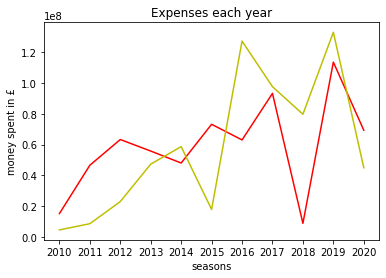

<Figure size 432x432 with 0 Axes>

In [405]:
# plotting expenses of both clubs for each season
plt.plot(seasons,fcb_expenses, 'r')
plt.plot(seasons,bvb_expenses, 'y')
plt.xticks(seasons)
plt.title('Expenses each year')
plt.ylabel('money spent in £')
plt.xlabel('seasons')
plt.figure(figsize=(6,6))
plt.show()

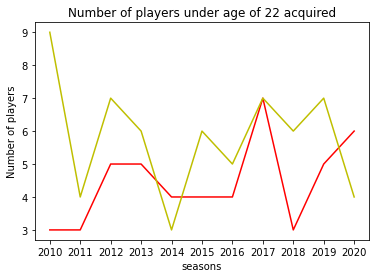

<Figure size 432x432 with 0 Axes>

In [406]:
# plotting number of new players under the age of 22 of both clubs for each season
plt.plot(seasons,fcb_young_talent, 'r')
plt.plot(seasons,bvb_young_talent, 'y')
plt.xticks(seasons)
plt.title('Number of players under age of 22 acquired')
plt.ylabel('Number of players')
plt.xlabel('seasons')
plt.figure(figsize=(6,6))
plt.show()

### How do FCB and BVB approach their transfer strategy? Are they buying well-known superstars for a lot of money or are they taking their chances with cheaper rookies?

### Conclusion:

Their approaches differ a lot. BVB had exceptional scouting  and  good second divison, so they got players like Lewandowski for only 5 million and promoted a lot of key players from their second divions in the early years of this decade. That was a good foundation for them, and they were successful as they won the Bundesliga in 2010/11 and 11/12. After that FCB became more agressive with their spending, not necessarily with their total amount of money spent, but with their approach. Each season in the early years of the decade they acquired at  least one good known quantity or even rising superstar  like Martinez,Neuer and Boateng. BVB always spread their budget thin and bought more players for less money as FCB took the risk to  buy one already well performing player and hopeing the player would keep performing/get even better. BVB almost always had the lower number in average age, concerning new players so it is true that BVB tried to develop rookies or less known players into superstarts, while FCB just took the risk on rising players and bought them for a lot of money.

### Has their approach changed over the years or e.g., after not winning the league?

### Conclusion: 

Yes and no. BVB always tried to promote a lot of talent from the second division and they also were good at scouting lesser known players from small clubs, sometimes from the bundesliga sometimes from foreign clubs. After not winning the league anymore and after FCB snatched their key players, they started to spend a bit more but their core principals stayed the same.

The strategy for FCB also remained the same over the years: Buy a one or two well known quantities for a lot of money each season, if possible weaken the rival in the bundesliga by aquiring their players. After Dortmund won in 10/11 and 11/12 they began to spend more and more to regain the throne and continued to stay on that level of spending money.

In [407]:
star_players_fcb=[]
star_players_bvb=[]
def star_player(df1,df2):
    
    for season in seasons:
        df1 = df1.groupby('direction').get_group('in')
        df2 = df2.groupby('direction').get_group('in')
        names1 = df1[df1.fee>20000].name
        names2 = df2[df2.fee>20000].name
        for name in names1:
            star_players_fcb.append(name)
        for name in names2:
            star_players_bvb.append(name)
star_player(transfers_fcb,transfers_bvb)

In [408]:
# counting the number of years transfers with fee > 20000 stayed at a club and putting the data into a df
number_of_years_fcb=[]
number_of_years_bvb=[]
for name in star_players_bvb:
    number_of_years_bvb.append(len(stats_bvb.groupby('name').get_group(name)))
for name in star_players_fcb:
    number_of_years_fcb.append(len(stats_fcb.groupby('name').get_group(name)))    
    
stay_at_club_bvb = pd.DataFrame({'player' : star_players_bvb,
                                'years stayed at club' : number_of_years_bvb})
stay_at_club_fcb = pd.DataFrame({'player' : star_players_fcb,
                                'years stayed at club' : number_of_years_fcb})


### How well is their transfer strategy panning out? Do newly bought players perform well immediately or are they flopping?

### How well are both teams developing their players? Are the players getting better/worse?

### How long are new transfers staying on the team? Do they become key players?

Now before those questions will be answered, there is the need to talk  about  soccer statistics. I scraped statistics but how much do they really mean in terms of 'how well has a player performed?'. Sure, a  striker or forward should score a lot of goals. But what about centere midfield players? Or defenders? The number of goals conceded for the whole team, does not represent how good or bad a certain player has performed as this stat is a result of the whole teams performance.

[statsperform] Most soccer statistics have  way  more data on hand than I do so I unfortunatly can't measure the performane as  well as they do. I will just go with this concept: If a player is performing decently well, the coach will let him start all the time. The only exception would be that the bad performing player has no better replacement on the bench so he plays anway. But since I've played soccer for 16 years of my life and have limited data, the way  to judge wether someone is perfoming well or not will mostly be by appearences and substutitions etc.

I know this approach is flawed but still a good compromise with the limited data I have.

###  Season 2010/11

In [409]:
get_names(transfers_fcb,transfers_bvb,2010)
stats_new_players(transfers_fcb,transfers_bvb,2010)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
4,Bayern Munich,David Alaba,18,Centre-Back,"DF,MF",5,2,0,0,0,0,0,0,0,0,2,0,22,,2010
6,Bayern Munich,Breno,20,Centre-Back,,19,13,0,0,0,0,0,0,0,1,6,0,731,,2010
8,Bayern Munich,Edson Braafheid,27,Left-Back,DF,13,3,0,0,0,0,0,0,0,0,1,2,140,,2010
13,Bayern Munich,Toni Kroos,20,Central Midfield,MF,27,27,1,5,1,0,0,3,0,0,8,8,1725,,2010
14,Bayern Munich,Luiz Gustavo,22,Defensive Midfield,"DF,MF",14,14,1,1,1,0,0,1,0,0,1,5,1073,,2010
15,Bayern Munich,José Sosa,25,Central Midfield,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2010
20,Bayern Munich,Andreas Ottl,25,Defensive Midfield,MF,31,15,0,1,0,0,0,0,0,0,6,1,914,,2010


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
0,Borussia Dortmund,Mitchell Langerak,21,Goalkeeper,GK,34,1,0,0,0,0,0,0,0,0,0,0,90,,2010
2,Borussia Dortmund,Johannes Focher,20,Goalkeeper,,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2010
4,Borussia Dortmund,Lasse Sobiech,19,Centre-Back,,4,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2010
12,Borussia Dortmund,Lukasz Piszczek,25,Right-Back,,34,33,0,7,0,0,0,2,0,0,4,0,2662,,2010
13,Borussia Dortmund,Mario Götze,18,Attacking Midfield,"FW,MF",33,33,6,15,6,0,0,1,0,0,4,15,2540,,2010
15,Borussia Dortmund,Shinji Kagawa,21,Attacking Midfield,"FW,MF",18,18,8,1,8,0,0,2,0,0,1,10,1371,,2010
16,Borussia Dortmund,Marco Stiepermann,19,Attacking Midfield,"FW,MF",6,4,0,0,0,0,0,0,0,0,4,0,24,,2010
18,Borussia Dortmund,Florian Kringe,27,Central Midfield,,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2010
23,Borussia Dortmund,Antônio da Silva,32,Attacking Midfield,MF,32,22,1,2,1,0,0,1,0,0,17,1,744,,2010
24,Borussia Dortmund,Robert Lewandowski,21,Centre-Forward,FW,34,33,8,3,8,0,0,4,0,0,18,9,1581,,2010


It is  clearly visible that new players at  BVB  get  way more  playtime from the  get go. Some even played every game of the season. At FCB new players did not appear that often. Lewandowski and Götze had  great  seasons with some goals and assits.

### Season 2011/2012

In [410]:
get_names(transfers_fcb,transfers_bvb,2011)
stats_new_players(transfers_fcb,transfers_bvb,2011)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
31,Bayern Munich,Manuel Neuer,25,Goalkeeper,GK,33,33,0,0,0,0,0,0,0,0,0,0,2970,,2011
32,Bayern Munich,Maximilian Riedmüller,23,Goalkeeper,,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2011
35,Bayern Munich,David Alaba,19,Centre-Back,"DF,MF",34,30,2,2,2,0,0,1,0,0,16,3,1532,,2011
36,Bayern Munich,Jérôme Boateng,22,Centre-Back,DF,30,27,0,1,0,0,0,3,0,1,1,4,2178,,2011
37,Bayern Munich,Rafinha,25,Right-Back,DF,31,24,0,3,0,0,0,7,0,0,4,4,1778,,2011
50,Bayern Munich,Nils Petersen,22,Centre-Forward,FW,28,9,2,0,2,0,0,0,0,0,7,2,213,,2011
51,Bayern Munich,Takashi Usami,19,Centre-Forward,"FW,MF",12,3,0,0,0,0,0,0,0,0,1,2,168,,2011


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
37,Borussia Dortmund,Chris Löwe,22,Left-Back,"DF,MF",23,7,0,0,0,0,0,0,0,0,1,1,569,,2011
43,Borussia Dortmund,Ilkay Gündogan,20,Central Midfield,,33,28,3,3,0,0,0,2,0,0,6,9,1907,,2011
45,Borussia Dortmund,Ivan Perisic,22,Left Midfield,,33,28,7,3,0,0,0,1,1,0,20,2,956,,2011
48,Borussia Dortmund,Moritz Leitner,18,Central Midfield,MF,27,17,0,2,0,0,0,0,0,0,15,1,466,,2011
49,Borussia Dortmund,Marvin Bakalorz,21,Defensive Midfield,,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2011
50,Borussia Dortmund,Julian Koch,20,Defensive Midfield,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2011


Now  both teams are using their newly bought players from the get go. Most of the bayern players were defenders, so juding their  performance is  hard but the midfielders from dortmund did a decent job  withsime assists and goals.


### Season 2012/13

In [411]:
get_names(transfers_fcb,transfers_bvb,2012)
stats_new_players(transfers_fcb,transfers_bvb,2012)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
57,Bayern Munich,Lukas Raeder,18,Goalkeeper,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2012
59,Bayern Munich,Tom Starke,31,Goalkeeper,GK,34,3,0,0,0,0,0,0,0,0,0,0,270,,2012
62,Bayern Munich,Mitchell Weiser,18,Right-Back,,4,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2012
63,Bayern Munich,Dante,28,Centre-Back,DF,32,29,1,2,1,0,0,4,0,0,0,0,2610,,2012
72,Bayern Munich,Emre Can,18,Defensive Midfield,"DF,MF",9,4,1,0,1,0,0,1,0,0,2,1,214,,2012
73,Bayern Munich,Javi Martínez,23,Defensive Midfield,"DF,MF",31,27,3,3,3,0,0,3,0,0,8,4,1758,,2012
75,Bayern Munich,Patrick Weihrauch,18,Attacking Midfield,,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2012
79,Bayern Munich,Xherdan Shaqiri,20,Right Winger,"FW,MF",32,26,4,6,4,0,0,1,0,0,13,7,1368,,2012
81,Bayern Munich,Mario Mandzukic,26,Centre-Forward,,30,24,15,3,0,0,0,2,0,0,2,19,1740,,2012
83,Bayern Munich,Claudio Pizarro,33,Centre-Forward,FW,27,20,6,7,6,0,0,0,0,0,13,3,744,,2012


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
61,Borussia Dortmund,Zlatan Alomerovic,21,Goalkeeper,,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2012
65,Borussia Dortmund,Koray Günter,17,Centre-Back,,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2012
69,Borussia Dortmund,Marc Hornschuh,21,Centre-Back,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2012
75,Borussia Dortmund,Marco Reus,23,Attacking Midfield,"FW,MF",32,32,14,11,14,0,0,4,0,0,5,13,2345,,2012
78,Borussia Dortmund,Leonardo Bittencourt,18,Attacking Midfield,"FW,MF",14,5,1,1,1,0,0,0,0,0,3,2,213,,2012
84,Borussia Dortmund,Nuri Sahin,23,Defensive Midfield,,17,15,3,3,0,0,0,0,0,0,6,0,891,,2012
85,Borussia Dortmund,Oliver Kirch,29,Defensive Midfield,"DF,MF",19,4,0,0,0,0,0,0,0,0,2,1,184,,2012
90,Borussia Dortmund,Julian Schieber,23,Centre-Forward,FW,33,23,3,0,3,0,0,3,1,0,17,1,785,,2012


Again, good playtime for the more expensive aquicitions. At FCB it  seems to be hard  for rookies to even get playtime.
Decent contributions  for most of the new players. Reus and Mandzukic both with really good seasons,while being the most expensive transfers respectively.

### Season 2013/14

In [412]:
get_names(transfers_fcb,transfers_bvb,2013)
stats_new_players(transfers_fcb,transfers_bvb,2013)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
93,Bayern Munich,Mitchell Weiser,19,Right-Back,"DF,MF",9,3,0,0,0,0,0,1,0,0,1,1,138,,2013
98,Bayern Munich,Jan Kirchhoff,22,Centre-Back,"DF,MF",12,7,0,0,0,0,0,1,0,0,7,0,82,,2013
102,Bayern Munich,Pierre-Emile Höjbjerg,17,Central Midfield,,15,7,0,1,0,0,0,0,0,0,5,0,281,,2013
104,Bayern Munich,Thiago,22,Central Midfield,,19,16,2,4,0,0,0,1,0,0,5,3,999,,2013
105,Bayern Munich,Mario Götze,21,Attacking Midfield,"FW,MF",29,27,10,9,10,0,0,0,0,0,7,11,1821,,2013
107,Bayern Munich,Alessandro Schöpf,19,Central Midfield,,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2013
108,Bayern Munich,Julian Green,18,Central Midfield,,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2013


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
97,Borussia Dortmund,Sokratis Papastathopoulos,25,Centre-Back,DF,32,28,1,2,1,0,0,4,1,0,4,1,2258,,2013
98,Borussia Dortmund,Erik Durm,21,Right-Back,"DF,FW",30,19,0,3,0,0,0,0,0,0,5,0,1381,,2013
101,Borussia Dortmund,Jannik Bandowski,19,Left-Back,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2013
102,Borussia Dortmund,Marian Sarr,18,Centre-Back,DF,9,2,0,0,0,0,0,1,0,0,0,1,135,,2013
103,Borussia Dortmund,Manuel Friedrich,33,Centre-Back,DF,20,11,1,1,1,0,0,2,0,0,3,0,794,,2013
108,Borussia Dortmund,Henrikh Mkhitaryan,24,Attacking Midfield,"FW,MF",32,31,9,10,9,0,0,6,0,0,2,19,2452,,2013
109,Borussia Dortmund,Milos Jojic,21,Central Midfield,,15,10,4,1,0,0,0,2,0,0,6,2,469,,2013
116,Borussia Dortmund,Jonas Hofmann,20,Right Winger,"FW,MF",34,26,2,6,2,0,0,1,0,0,22,3,669,,2013
117,Borussia Dortmund,Pierre-Emerick Aubameyang,24,Centre-Forward,"FW,MF",33,32,13,4,13,0,0,1,0,0,11,12,1955,,2013
118,Borussia Dortmund,Marvin Ducksch,19,Centre-Forward,FW,12,6,0,0,0,0,0,0,0,0,5,0,150,,2013


Not a lot of playtime for most of the new munich players. Dormund in comparison played their new players a lot more often.

### Season 204/15

In [413]:
get_names(transfers_fcb,transfers_bvb,2014)
stats_new_players(transfers_fcb,transfers_bvb,2014)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
118,Bayern Munich,Pepe Reina,31,Goalkeeper,GK,23,3,0,0,0,0,0,0,0,1,0,0,193,,2014
119,Bayern Munich,Ivan Lucic,19,Goalkeeper,GK,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2014
123,Bayern Munich,Juan Bernat,21,Left-Back,"DF,FW",34,31,1,1,1,0,0,1,0,0,3,2,2554,,2014
129,Bayern Munich,Medhi Benatia,27,Centre-Back,DF,24,15,1,0,1,0,0,5,0,0,2,2,1151,,2014
135,Bayern Munich,Sebastian Rode,23,Central Midfield,MF,31,23,2,5,2,0,0,2,0,0,15,2,959,,2014
139,Bayern Munich,Gianluca Gaudino,17,Central Midfield,MF,24,8,0,0,0,0,0,0,0,0,4,3,373,,2014
141,Bayern Munich,Xabi Alonso,32,Defensive Midfield,MF,30,26,2,3,2,0,0,6,0,0,2,11,1972,,2014
143,Bayern Munich,Robert Lewandowski,25,Centre-Forward,FW,32,31,17,7,16,1,1,0,0,0,3,11,2487,,2014
147,Bayern Munich,Sinan Kurt,17,Left Winger,"FW,MF",6,1,0,0,0,0,0,0,0,0,1,0,44,,2014
148,Bayern Munich,Sinan Kurt,17,Left Winger,MF,6,1,0,0,0,0,0,0,0,0,1,0,44,,2014


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
125,Borussia Dortmund,Hendrik Bonmann,20,Goalkeeper,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2014
127,Borussia Dortmund,Matthias Ginter,20,Centre-Back,"DF,MF",31,14,0,1,0,0,0,1,0,0,5,0,838,,2014
142,Borussia Dortmund,Kevin Kampl,23,Central Midfield,MF,15,13,0,2,0,0,0,2,0,0,5,6,720,,2014
146,Borussia Dortmund,Jeremy Dudziak,18,Attacking Midfield,"DF,MF",5,3,0,1,0,0,0,0,0,0,3,0,60,,2014
147,Borussia Dortmund,Shinji Kagawa,25,Attacking Midfield,MF,32,28,5,6,5,0,0,2,0,0,5,16,1878,,2014
152,Borussia Dortmund,Nuri Sahin,25,Defensive Midfield,,11,7,1,0,0,0,0,0,0,0,1,1,544,,2014
154,Borussia Dortmund,Ciro Immobile,24,Centre-Forward,FW,32,24,3,1,3,0,1,1,0,0,15,3,956,,2014
157,Borussia Dortmund,Adrián Ramos,28,Centre-Forward,FW,23,18,2,2,2,0,0,1,0,0,12,4,709,,2014


Good playtime  for most of the new players. Immobile couln't replace lewandowski as he only scored 3 goals. Lewandowski at FCB scored a whopping 17. Thats exactly the kind  of performane gap mentioned earlier.


### Season 2015/16

In [414]:
get_names(transfers_fcb,transfers_bvb,2015)
stats_new_players(transfers_fcb,transfers_bvb,2015)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
152,Bayern Munich,Sven Ulreich,26,Goalkeeper,GK,30,1,0,0,0,0,0,0,0,0,1,0,39,,2015
162,Bayern Munich,Jan Kirchhoff,24,Centre-Back,"DF,MF",7,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2015
163,Bayern Munich,Serdar Tasci,28,Centre-Back,DF,10,3,0,0,0,0,0,1,0,0,0,2,220,,2015
166,Bayern Munich,Joshua Kimmich,20,Defensive Midfield,"DF,MF",32,23,0,2,0,0,0,3,0,0,8,2,1422,,2015
167,Bayern Munich,Pierre-Emile Höjbjerg,19,Central Midfield,,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2015
172,Bayern Munich,Arturo Vidal,28,Central Midfield,MF,33,30,4,7,4,0,0,3,0,0,6,10,2048,,2015
174,Bayern Munich,Julian Green,20,Central Midfield,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2015
179,Bayern Munich,Kingsley Coman,19,Right Winger,"MF,FW",27,23,4,6,4,0,0,0,0,0,3,7,1690,,2015
182,Bayern Munich,Douglas Costa,24,Right Winger,MF,30,27,4,14,4,0,0,1,0,0,4,10,1971,,2015


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
159,Borussia Dortmund,Roman Bürki,24,Goalkeeper,GK,33,33,0,0,0,0,0,1,0,0,0,0,2970,,2015
165,Borussia Dortmund,Felix Passlack,17,Right-Back,"FW,DF",4,3,0,0,0,0,0,0,0,0,1,1,181,,2015
167,Borussia Dortmund,Pascal Stenzel,19,Centre-Back,"DF,MF",3,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2015
170,Borussia Dortmund,Ju-ho Park,28,Left-Back,,15,5,0,0,0,0,0,0,0,0,1,2,309,,2015
174,Borussia Dortmund,Julian Weigl,19,Defensive Midfield,MF,31,30,0,0,0,0,0,5,0,0,5,6,2248,,2015
180,Borussia Dortmund,Gonzalo Castro,28,Central Midfield,MF,33,25,3,7,3,0,0,1,0,0,9,9,1482,,2015
181,Borussia Dortmund,Moritz Leitner,22,Central Midfield,MF,16,9,0,2,0,0,0,0,0,0,7,1,320,,2015
184,Borussia Dortmund,Christian Pulisic,16,Right Winger,"MF,FW",11,9,2,0,2,0,0,1,0,0,5,3,386,,2015
185,Borussia Dortmund,Jonas Hofmann,22,Right Winger,"MF,FW",15,7,1,2,1,0,0,0,0,0,3,4,287,,2015
187,Borussia Dortmund,Adnan Januzaj,20,Right Winger,"FW,MF",12,6,0,2,0,0,0,0,0,0,6,0,161,,2015


Costa doing very well in his first season for FCB, so  does the young Kimmich and Coman. BVB got a new main goalkeeper in Bürki and two now starters in Weigel and Castro. The other often very young players, still see  some  playtime  at BVB.

### Season 2016/17

In [415]:
get_names(transfers_fcb,transfers_bvb,2016)
stats_new_players(transfers_fcb,transfers_bvb,2016)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
191,Bayern Munich,Mats Hummels,27,Centre-Back,DF,29,27,1,2,1,0,0,4,0,0,3,3,2181,,2016
201,Bayern Munich,Renato Sanches,18,Central Midfield,MF,32,17,0,0,0,0,0,3,0,0,11,5,615,,2016
203,Bayern Munich,Niklas Dorsch,18,Defensive Midfield,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2016
210,Bayern Munich,Fabian Benko,18,Attacking Midfield,MF,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2016


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
192,Borussia Dortmund,Raphaël Guerreiro,22,Left-Back,MF,26,24,6,5,6,0,0,0,0,0,7,9,1484,,2016
194,Borussia Dortmund,Marc Bartra,25,Centre-Back,DF,28,19,0,4,0,0,0,5,0,0,1,2,1560,,2016
202,Borussia Dortmund,Mikel Merino,20,Central Midfield,DF,14,8,0,0,0,0,0,1,0,0,6,0,292,,2016
205,Borussia Dortmund,Mario Götze,24,Attacking Midfield,MF,17,11,1,1,1,0,0,1,0,0,2,5,763,,2016
206,Borussia Dortmund,Sebastian Rode,25,Central Midfield,MF,16,14,1,0,1,0,0,0,0,0,9,3,575,,2016
209,Borussia Dortmund,Dzenis Burnic,18,Defensive Midfield,,3,1,0,0,0,0,0,1,0,0,0,0,90,,2016
213,Borussia Dortmund,Alexander Isak,16,Centre-Forward,FW,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2016
214,Borussia Dortmund,Ousmane Dembélé,19,Right Winger,"MF,FW",33,32,6,13,6,0,0,7,0,0,10,14,2040,,2016
217,Borussia Dortmund,Emre Mor,18,Right Winger,"MF,FW",21,12,1,2,1,0,0,0,0,1,7,4,475,,2016
219,Borussia Dortmund,André Schürrle,25,Left Winger,"MF,FW",18,15,2,3,1,1,1,3,0,0,7,3,744,,2016


Rookies at Bayern   with no time on  the  pitch  whatsoever. The known quantity  in Hummels is immediately a starter.
BVB   got a lot of new players and almost  all of them had some time on the pitch, with Dembele their most expesive tranfers being a starter and having a decent season with 6 goals and 13 assisits.


### Season 2017/18

In [416]:
get_names(transfers_fcb,transfers_bvb,2017)
stats_new_players(transfers_fcb,transfers_bvb,2017)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
221,Bayern Munich,Christian Früchtl,17,Goalkeeper,GK,3,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2017
223,Bayern Munich,Tom Starke,36,Goalkeeper,GK,28,2,0,0,0,0,0,0,0,0,0,0,180,,2017
225,Bayern Munich,Niklas Süle,21,Centre-Back,DF,34,27,2,1,2,0,0,1,0,0,7,0,1919,,2017
229,Bayern Munich,Marco Friedl,19,Centre-Back,DF,7,1,0,0,0,0,0,0,0,0,1,0,44,,2017
236,Bayern Munich,James Rodríguez,25,Attacking Midfield,MF,28,23,7,11,7,0,0,2,0,0,4,8,1623,,2017
237,Bayern Munich,Corentin Tolisso,22,Central Midfield,MF,32,26,6,4,6,0,0,3,0,0,9,6,1526,,2017
240,Bayern Munich,Sebastian Rudy,27,Defensive Midfield,MF,33,25,1,4,1,0,0,2,0,0,9,3,1509,,2017
244,Bayern Munich,Felix Götze,19,Defensive Midfield,DF,3,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2017
247,Bayern Munich,Kingsley Coman,21,Right Winger,"FW,MF",21,21,3,4,3,0,0,0,0,0,11,4,1148,,2017
254,Bayern Munich,Sandro Wagner,29,Centre-Forward,FW,17,14,8,2,8,0,0,1,0,0,6,4,722,,2017


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
221,Borussia Dortmund,Dominik Reimann,20,Goalkeeper,GK,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2017
224,Borussia Dortmund,Manuel Akanji,21,Centre-Back,DF,15,11,0,0,0,0,0,2,0,0,1,0,903,,2017
225,Borussia Dortmund,Dan-Axel Zagadou,18,Centre-Back,DF,22,11,1,0,1,0,0,0,0,1,5,2,651,,2017
226,Borussia Dortmund,Sergio Gómez,16,Left-Back,MF,3,2,0,0,0,0,0,0,0,0,2,0,7,,2017
228,Borussia Dortmund,Jeremy Toljan,22,Right-Back,DF,20,16,1,2,1,0,0,1,0,0,3,1,1208,,2017
232,Borussia Dortmund,Ömer Toprak,27,Centre-Back,DF,29,26,0,2,0,0,0,1,0,0,4,2,2017,,2017
234,Borussia Dortmund,Neven Subotic,28,Centre-Back,,9,4,0,0,0,0,0,1,0,0,1,0,270,,2017
237,Borussia Dortmund,Mahmoud Dahoud,21,Central Midfield,MF,26,23,0,4,0,0,0,4,0,0,12,5,1137,,2017
244,Borussia Dortmund,Jadon Sancho,17,Left Winger,FW,15,12,1,4,1,0,0,0,0,0,5,0,685,,2017
249,Borussia Dortmund,Michy Batshuayi,23,Centre-Forward,FW,10,10,7,1,7,0,0,2,0,0,1,1,838,,2017


FCB got some new key players in Süle and Tolisso and Wagner. BVB on the other hand bought a lot of new talent. But only 3 of the 13 new players had more than 20 appearences.


### Season 2018/19

In [417]:
get_names(transfers_fcb,transfers_bvb,2018)
stats_new_players(transfers_fcb,transfers_bvb,2018)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
259,Bayern Munich,Ron-Thorben Hoffmann,19,Goalkeeper,GK,5,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2018
260,Bayern Munich,Alphonso Davies,17,Left-Back,"FW,MF",13,6,1,0,1,0,0,1,0,0,6,0,74,,2018
271,Bayern Munich,Leon Goretzka,23,Central Midfield,MF,30,30,8,5,8,0,0,3,0,0,7,5,2020,,2018
272,Bayern Munich,Renato Sanches,20,Central Midfield,MF,30,17,1,1,1,0,0,1,1,0,13,2,567,,2018
280,Bayern Munich,Serge Gnabry,22,Right Winger,"FW,MF",30,30,10,7,10,0,0,0,0,0,9,18,1770,,2018


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
257,Borussia Dortmund,Marwin Hitz,30,Goalkeeper,GK,33,2,0,0,0,0,0,1,0,0,0,0,180,,2018
258,Borussia Dortmund,Eric Oelschlägel,22,Goalkeeper,GK,3,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2018
259,Borussia Dortmund,Achraf Hakimi,19,Right-Back,DF,27,21,2,4,2,0,0,4,0,0,2,2,1739,,2018
262,Borussia Dortmund,Abdou Diallo,22,Left-Back,DF,28,28,1,1,1,0,0,1,0,1,1,2,2383,,2018
263,Borussia Dortmund,Leonardo Balerdi,19,Centre-Back,DF,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2018
268,Borussia Dortmund,Felix Passlack,20,Right-Back,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2018
276,Borussia Dortmund,Thomas Delaney,26,Defensive Midfield,MF,32,30,3,6,3,0,0,7,0,0,3,8,2287,,2018
277,Borussia Dortmund,Axel Witsel,29,Defensive Midfield,MF,33,33,4,1,4,0,0,2,0,0,1,1,2873,,2018
280,Borussia Dortmund,Dzenis Burnic,20,Defensive Midfield,,0,0,0,0,0,0,0,0,0,0,0,0,0,Not in squad during this season,2018
282,Borussia Dortmund,Christian Pulisic,19,Right Winger,"FW,MF",24,20,4,4,4,0,0,2,0,0,11,3,926,,2018


FCB again with a low amount of new players, but the  players they  bought are playing a lot and they seem to be playing well.
BVB got a lot of  new  players and most of them played a good amount of matches. Paco Alcácer had a remarkable season with 18 goals at his first season at  dortmund.

### Season 2019/2020

In [418]:
get_names(transfers_fcb,transfers_bvb,2019)
stats_new_players(transfers_fcb,transfers_bvb,2019)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
294,Bayern Munich,Lucas Hernández,23,Centre-Back,DF,21,19,0,1,0,0,0,3,0,0,9,4,913,,2019
296,Bayern Munich,Benjamin Pavard,23,Right-Back,DF,33,32,4,5,4,0,0,5,0,0,1,1,2790,,2019
297,Bayern Munich,Álvaro Odriozola,23,Right-Back,DF,16,3,0,0,0,0,0,0,0,0,1,2,153,,2019
300,Bayern Munich,Lars Lukas Mai,19,Centre-Back,DF,15,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2019
308,Bayern Munich,Ivan Perisic,30,Left Midfield,,25,22,4,6,0,0,0,1,0,0,11,7,1202,,2019
309,Bayern Munich,Michaël Cuisance,19,Central Midfield,,27,9,1,1,0,0,0,1,0,0,6,2,302,,2019
318,Bayern Munich,Philippe Coutinho,27,Left Winger,"MF,FW",25,23,8,6,7,1,1,0,0,0,8,10,1414,,2019
325,Bayern Munich,Fiete Arp,19,Centre-Forward,,2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2019


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
290,Borussia Dortmund,Luca Unbehaun,18,Goalkeeper,GK,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2019
299,Borussia Dortmund,Mats Hummels,30,Centre-Back,DF,31,31,1,3,1,0,0,6,1,0,0,4,2583,,2019
300,Borussia Dortmund,Nico Schulz,26,Left-Back,DF,25,11,1,0,1,0,0,0,0,0,4,2,591,,2019
301,Borussia Dortmund,Mateu Morey Bauzà,19,Right-Back,,21,5,0,1,0,0,0,0,0,0,3,1,195,,2019
306,Borussia Dortmund,Giovanni Reyna,16,Attacking Midfield,,17,15,0,1,0,0,0,2,0,0,13,2,343,,2019
307,Borussia Dortmund,Julian Brandt,23,Attacking Midfield,"MF,FW",33,33,3,8,3,0,0,0,0,0,8,14,2208,,2019
310,Borussia Dortmund,Emre Can,25,Defensive Midfield,"MF,DF",12,12,2,1,2,0,0,5,0,0,2,3,956,,2019
317,Borussia Dortmund,Tobias Raschl,19,Central Midfield,MF,11,1,0,0,0,0,0,0,0,0,1,0,25,,2019
319,Borussia Dortmund,Erling Haaland,18,Centre-Forward,FW,15,15,13,3,13,0,0,0,0,0,4,4,1063,,2019
321,Borussia Dortmund,Thorgan Hazard,26,Left Winger,"FW,MF",33,33,7,13,7,0,0,3,0,0,5,17,2391,,2019


The trend continues as FCB buys less players, but they get more playtime. Dortmund got Hummels back and hes a starter from the get go. BVB  also got the young prodigy  in Erling Haaland who had a phenomal starting season with 13 goals in 15 matches.

### Season 2020/21

In [419]:
get_names(transfers_fcb,transfers_bvb,2020)
stats_new_players(transfers_fcb,transfers_bvb,2020)

,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
327,Bayern Munich,Alexander Nübel,23,Goalkeeper,GK,27,1,0,0,0,0,0,0,0,0,0,0,90,,2020
336,Bayern Munich,Tanguy Nianzou,18,Centre-Back,,9,6,0,0,0,0,0,1,0,1,6,0,113,,2020
337,Bayern Munich,Chris Richards,20,Centre-Back,DF,11,3,0,1,0,0,0,0,0,0,2,1,88,,2020
340,Bayern Munich,Bouna Sarr,28,Right-Back,DF,25,8,0,1,0,0,0,1,0,0,3,1,450,,2020
347,Bayern Munich,Jamal Musiala,17,Attacking Midfield,"FW,MF",34,26,6,1,6,0,0,0,0,0,19,7,869,,2020
349,Bayern Munich,Marc Roca,23,Defensive Midfield,MF,26,6,0,0,0,0,0,1,0,0,4,2,174,,2020
353,Bayern Munich,Tiago Dantas,19,Central Midfield,MF,12,2,0,0,0,0,0,0,0,0,1,1,69,,2020
356,Bayern Munich,Adrian Fein,21,Defensive Midfield,MF,1,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2020
360,Bayern Munich,Leroy Sané,24,Left Winger,"FW,MF",32,32,6,10,6,0,0,2,0,0,14,16,1804,,2020
364,Bayern Munich,Joshua Zirkzee,19,Centre-Forward,FW,5,3,0,0,0,0,0,0,0,0,2,1,91,,2020


,club,name,age,position,position_adv,in_squad,appearances,goals,assists,g_pk,PK,PKatt,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,minutes_played,info,season
334,Borussia Dortmund,Thomas Meunier,28,Right-Back,DF,28,21,1,1,1,0,0,3,0,0,4,7,1474,,2020
337,Borussia Dortmund,Felix Passlack,22,Right-Back,DF,21,7,1,0,1,0,0,0,0,0,4,1,358,,2020
340,Borussia Dortmund,Jude Bellingham,17,Central Midfield,MF,31,29,1,3,1,0,0,4,1,0,10,13,1700,,2020
344,Borussia Dortmund,Emre Can,26,Defensive Midfield,"DF,MF",31,28,1,4,1,0,0,5,0,0,5,4,2132,,2020
346,Borussia Dortmund,Reinier,18,Attacking Midfield,"MF,FW",27,14,1,1,1,0,0,0,0,0,13,1,245,,2020
353,Borussia Dortmund,Youssoufa Moukoko,15,Centre-Forward,"FW,MF",18,14,3,0,3,0,0,0,0,0,12,1,410,,2020
354,Borussia Dortmund,Marius Wolf,25,Right Winger,"DF,FW",2,0,0,0,0,0,0,0,0,0,0,0,0,Not used during this season,2020
356,Borussia Dortmund,Steffen Tigges,21,Centre-Forward,"FW,DF",14,6,0,0,0,0,0,0,0,0,6,0,49,,2020


Leroy Sane can't deliever the performance he should have as he was one of the most expensive transfers for FCB. However the young Musiala had 26 appearences with 6 goals, which is ordinary that a rookie at FCB gets this much playtime and also performs this well. At Dortmund Bellingham played 29 matches wich  is a lot for a 17 year old rookie. They also strengthen their sqaud with players like Meunier and Can, which saw a lot of playtime.

# Conclusion

For Bayern most of their new players  perform well from the get go and contribute towards the teams sucess. But that is probably because they buy a lot of established players with good experience and good form.They do not  buy as  many new players as dortmund does but spend on some heavy hitters. At FCB, barely any rookies get to play, even though they are bought/aquired. Some say that FCB is wasting young talent on their bench.

BVB givs rookies more of a chance but  it became evident that they do not fill in the gaps that players  like Lewandwoski or  Götze  left behind, right away.

But transfer strategys are panning out:

FCB buys good expensive players and incoporates  them  to their squad.  They do well, but they have to pay a lot of money in transfers. They get good results most of the time right away and stay on top of the Bundesliga like that.

BVB on the other hand gives rookies more of a chance  and  develops  some really good playersm,  wich  are unfortunatly moving away striving for more sucess, like Lewandowski for example. The rookies get playtime right away and while most of them do not hit the ground running,  they  develop  into decent players.  But BVB also has some really good scounting, which  helped them discover diamonds in the rough like Haaland who scored 13 goals at 15 games in his first season.

Overall it feels like the 2  clubs have different approaches:

Dortmund tries to get that lucky draw with youn prodigys and  FCB know what they want  and get from a certain players, striving for sucess in the Bundesliga but more importantly internationally.

# References


[1]	CW1



## Resources used : Webscraping

-	Webscraping lecture and lab, Data Programming, Sean McGrath

-	Human Code. 2019. Web scraping with Python using Requests and LXML - Crash course. https://youtu.be/JyIuMooTRFA

-	https://lxml.de/index.html#documentation

-	2018. Web Scraping using lxml and Python 2018: Extracting data from Steam. https://www.youtube.com/watch?v=5N066ISH8og


## Rosources used: Data cleaning and processing




-	DSM020-01 - Data Programming, lectures and labs, Sean McGrath

-	https://pandas.pydata.org/docs/index.html

-	Corey Schafer. Python Pandas Tutorial (Part 9): Cleaning Data - Casting Datatypes and Handling Missing Values.     https://www.youtube.com/watch?v=KdmPHEnPJPs

-	https://stackoverflow.com/questions/37428218/how-to-properly-apply-a-lambda-function-into-a-pandas-data-frame-column


## Rosources used: EDA


-	Lectures from several other modules as basic knowdlege

-	DSM020-01 - Data Programming, lectures and labs, Sean McGrath

-	stackoverflow.com

-	DataCamp. Python Tutorial: Plotting multiple graphs. https://youtu.be/-2AMr95nUDw